In [1]:
library(repr)
options(repr.plot.width=15, repr.plot.height=11)

In [2]:
if ("spatialreg" %in% rownames(installed.packages()) == FALSE) {
    install.packages("spatialreg")
}

library(spatialreg)

Loading required package: spData
Loading required package: Matrix
Loading required package: sf
Linking to GEOS 3.9.1, GDAL 3.2.2, PROJ 8.0.0


In [3]:
library(tidyverse)
library(tmap)
library(sf)
library(spdep)
library(spatialreg)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
Loading required package: sp

Attaching package: ‘spdep’

The following objects are masked from ‘package:spatialreg’:

    aple, aple.mc, aple.plot, as_dgRMatrix_listw, as_dsCMatrix_I,
    as_dsCMatrix_IrW, as_dsTMatrix_listw, as.spam

## CV ratio and latitude

In [4]:
world.160e <- read_sf("data/world_160e.gpkg") %>%
    filter(iso_a2 != 'AQ')

bg.map <- world.160e %>% 
    st_transform("+proj=eqearth lon_0=160") %>%
    tm_shape() +
    tm_fill()

In [5]:
cvRatio <- read_csv("data/asjp_cvRatio.csv") %>%
    drop_na() %>%
    filter(cvRatio < Inf) %>%
    st_as_sf(coords = c("Longitude", "Latitude")) 


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Name = col_character(),
  Longitude = col_double(),
  Latitude = col_double(),
  cvRatio = col_double()
)



In [6]:
coor.cv <- cvRatio %>% 
    st_coordinates()
coor.cv %>% head()

X     Y   
1 11.20 5.10
2 11.20 5.10
3 11.17 5.00
4 11.30 5.30
5 11.25 4.58
6 11.08 4.50

In [7]:
d1 <- cvRatio %>%
    mutate(longitude = coor.cv[,1]) %>%
    mutate(latitude = coor.cv[,2]) %>%
    mutate(lat = abs(latitude))
d1 %>%
    slice_head(n=4)

Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.9.1-CAPI-1.14.2
and GEOS at installation 3.9.1dev-CAPI-1.14.1differ”Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Name                  cvRatio  geometry         longitude latitude lat
1 A51_BAFIA_MAJA        2.066667 POINT (11.2 5.1) 11.20     5.1      5.1
2 A51_BAFIA_TUMI_TINGON 1.720000 POINT (11.2 5.1) 11.20     5.1      5.1
3 A53_BAFIA_RIKPA       1.020833 POINT (11.17 5)  11.17     5.0      5.0
4 A54_BAFIA_NJANTI      1.500000 POINT (11.3 5.3) 11.30     5.3      5.3

In [8]:
st_crs(d1) <- 4326

In [9]:
v <- d1 %>%
    st_geometry() %>%
    st_coordinates() %>%
    st_multipoint() %>% 
    st_voronoi()  
v_sfc <- v %>%
    lapply(function(x) x) %>%
    st_sfc()
st_crs(v_sfc) <- 4326
cvVoronoi <- v_sfc %>% 
    st_sf() %>%
    st_join(d1) %>%
    st_intersection(st_union(world.160e))


Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”although coordinates are longitude/latitude, st_intersects assumes that they are planar
although coordinates are longitude/latitude, st_union assumes that they are planar
Warning message in st_is_longlat(x):
“bounding box has potentially an invalid value range for longlat data”although coordinates are longitude/latitude, st_intersection assumes that they are planar
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”

In [10]:
cv_nb <- poly2nb(cvVoronoi, queen=TRUE)
cv_lw <- nb2listw(cv_nb, style="W", zero.policy = T)

In [11]:
lat.lag = lag.listw(cv_lw, abs(cvVoronoi$latitude), zero.policy = T)
cv.lag = lag.listw(cv_lw, cvVoronoi$cvRatio, zero.policy = T)

In [12]:
cvVoronoi.smoothed <- cvVoronoi %>%
    mutate(latSmoothed = lat.lag) %>%
    mutate(cvSmoothed = cv.lag)

In [13]:
p5 <- cvVoronoi.smoothed %>%
    drop_na() %>%
    st_transform("+proj=eqearth lon_0=160") %>%
    tm_shape() +
    tm_fill(col="latSmoothed", style="quantile", palette = "RdYlBu") +
    tm_layout(legend.outside=T, bg.color = 'grey', scale=2)

In [14]:
p6 <- cvVoronoi.smoothed %>%
    drop_na() %>%
    st_transform("+proj=eqearth lon_0=160") %>%
    tm_shape() +
    tm_fill(col="cvSmoothed", style="quantile", palette = "RdYlBu") +
    tm_layout(legend.outside=T, bg.color = 'grey', scale=2)

Some legend labels were too wide. These labels have been resized to 1.20, 1.10, 1.10. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.
Legend labels were too wide. The labels have been resized to 1.1, 1.1, 1.1, 1.1, 1.1. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.


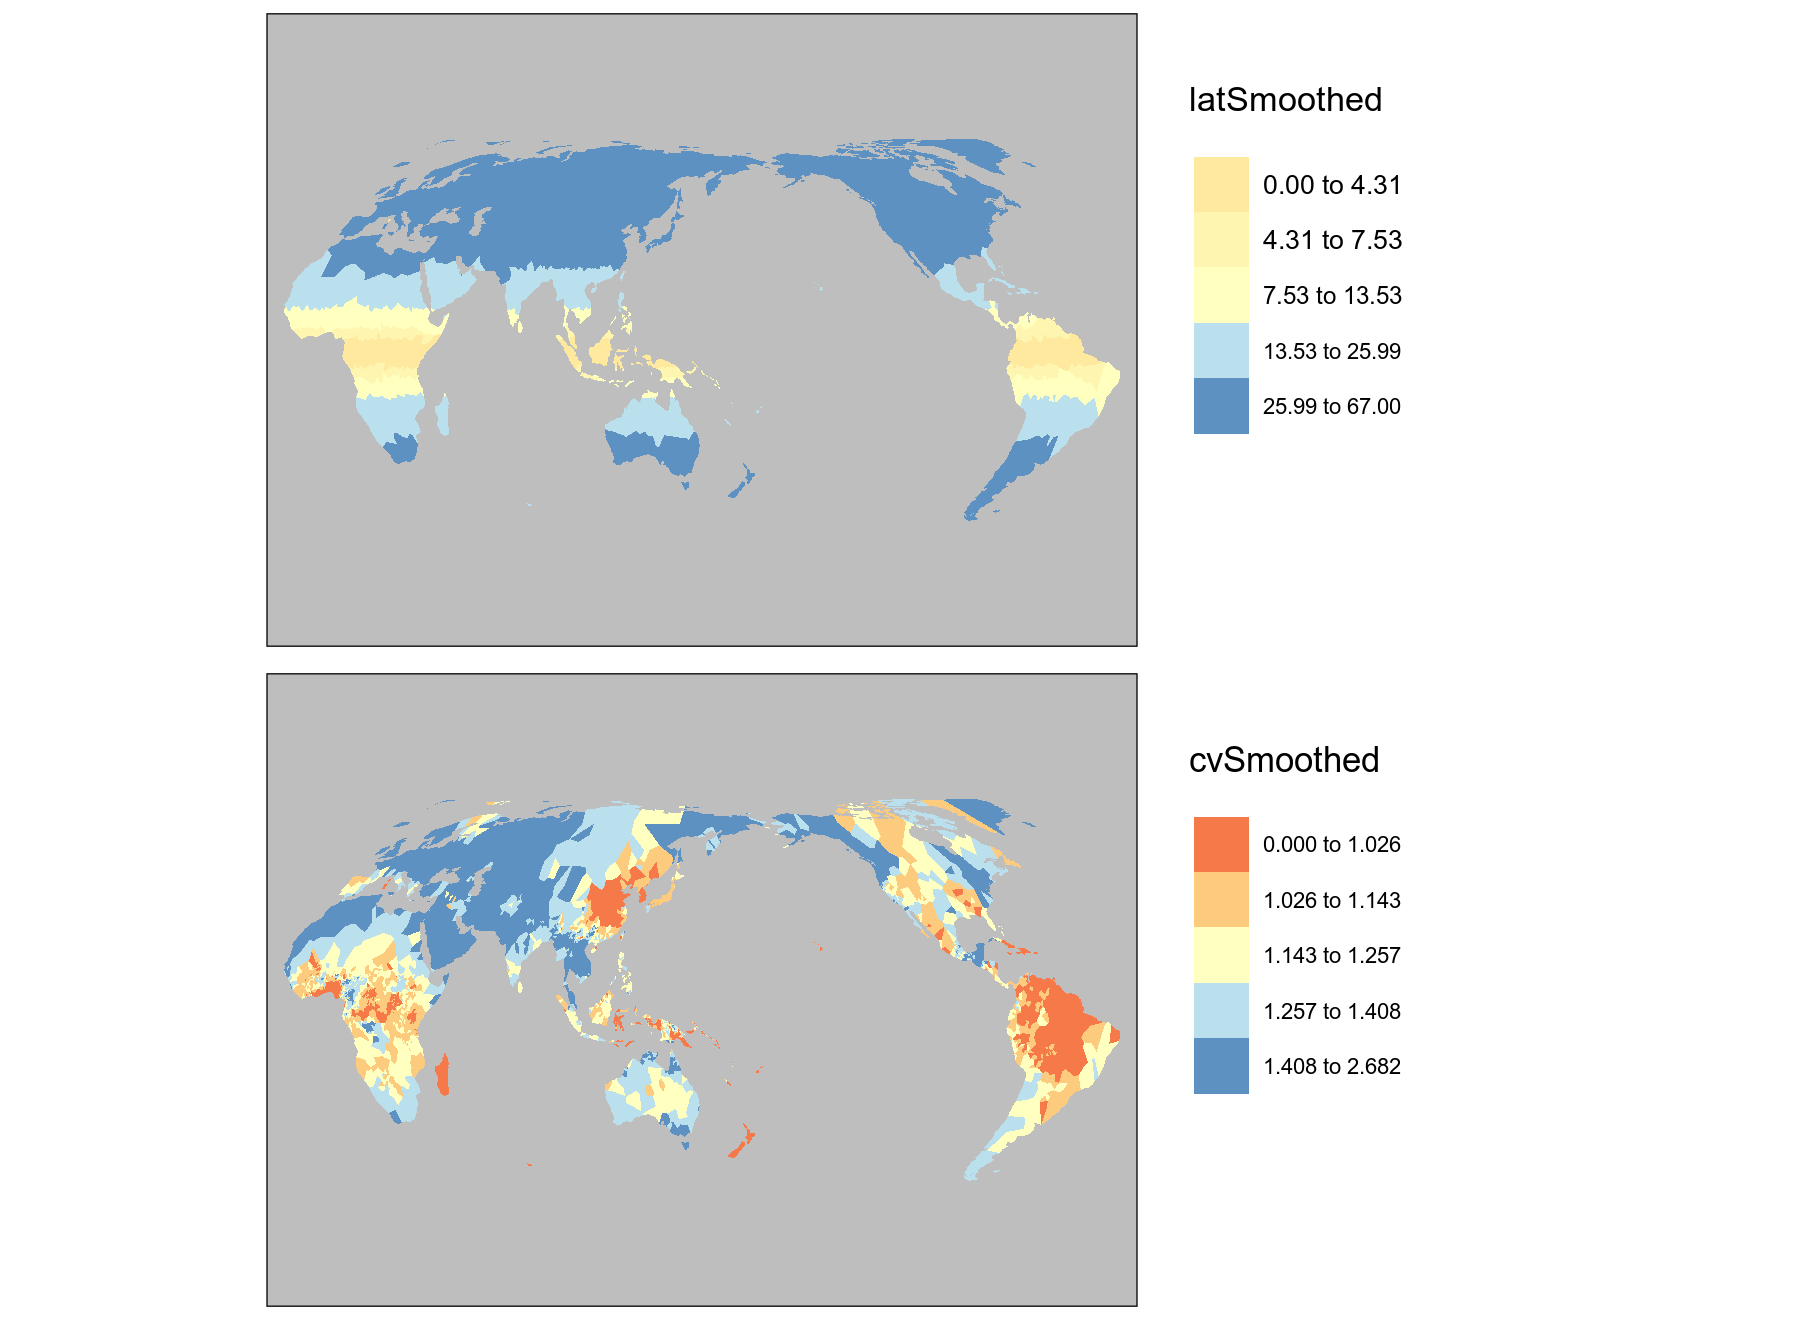

In [15]:
tmap_arrange(p5, p6)

In [16]:
d1 %>%
    mutate(latSc = scale(lat)) %>%
    mutate(cvSc = scale(cvRatio)) -> d1

`geom_smooth()` using formula 'y ~ x'


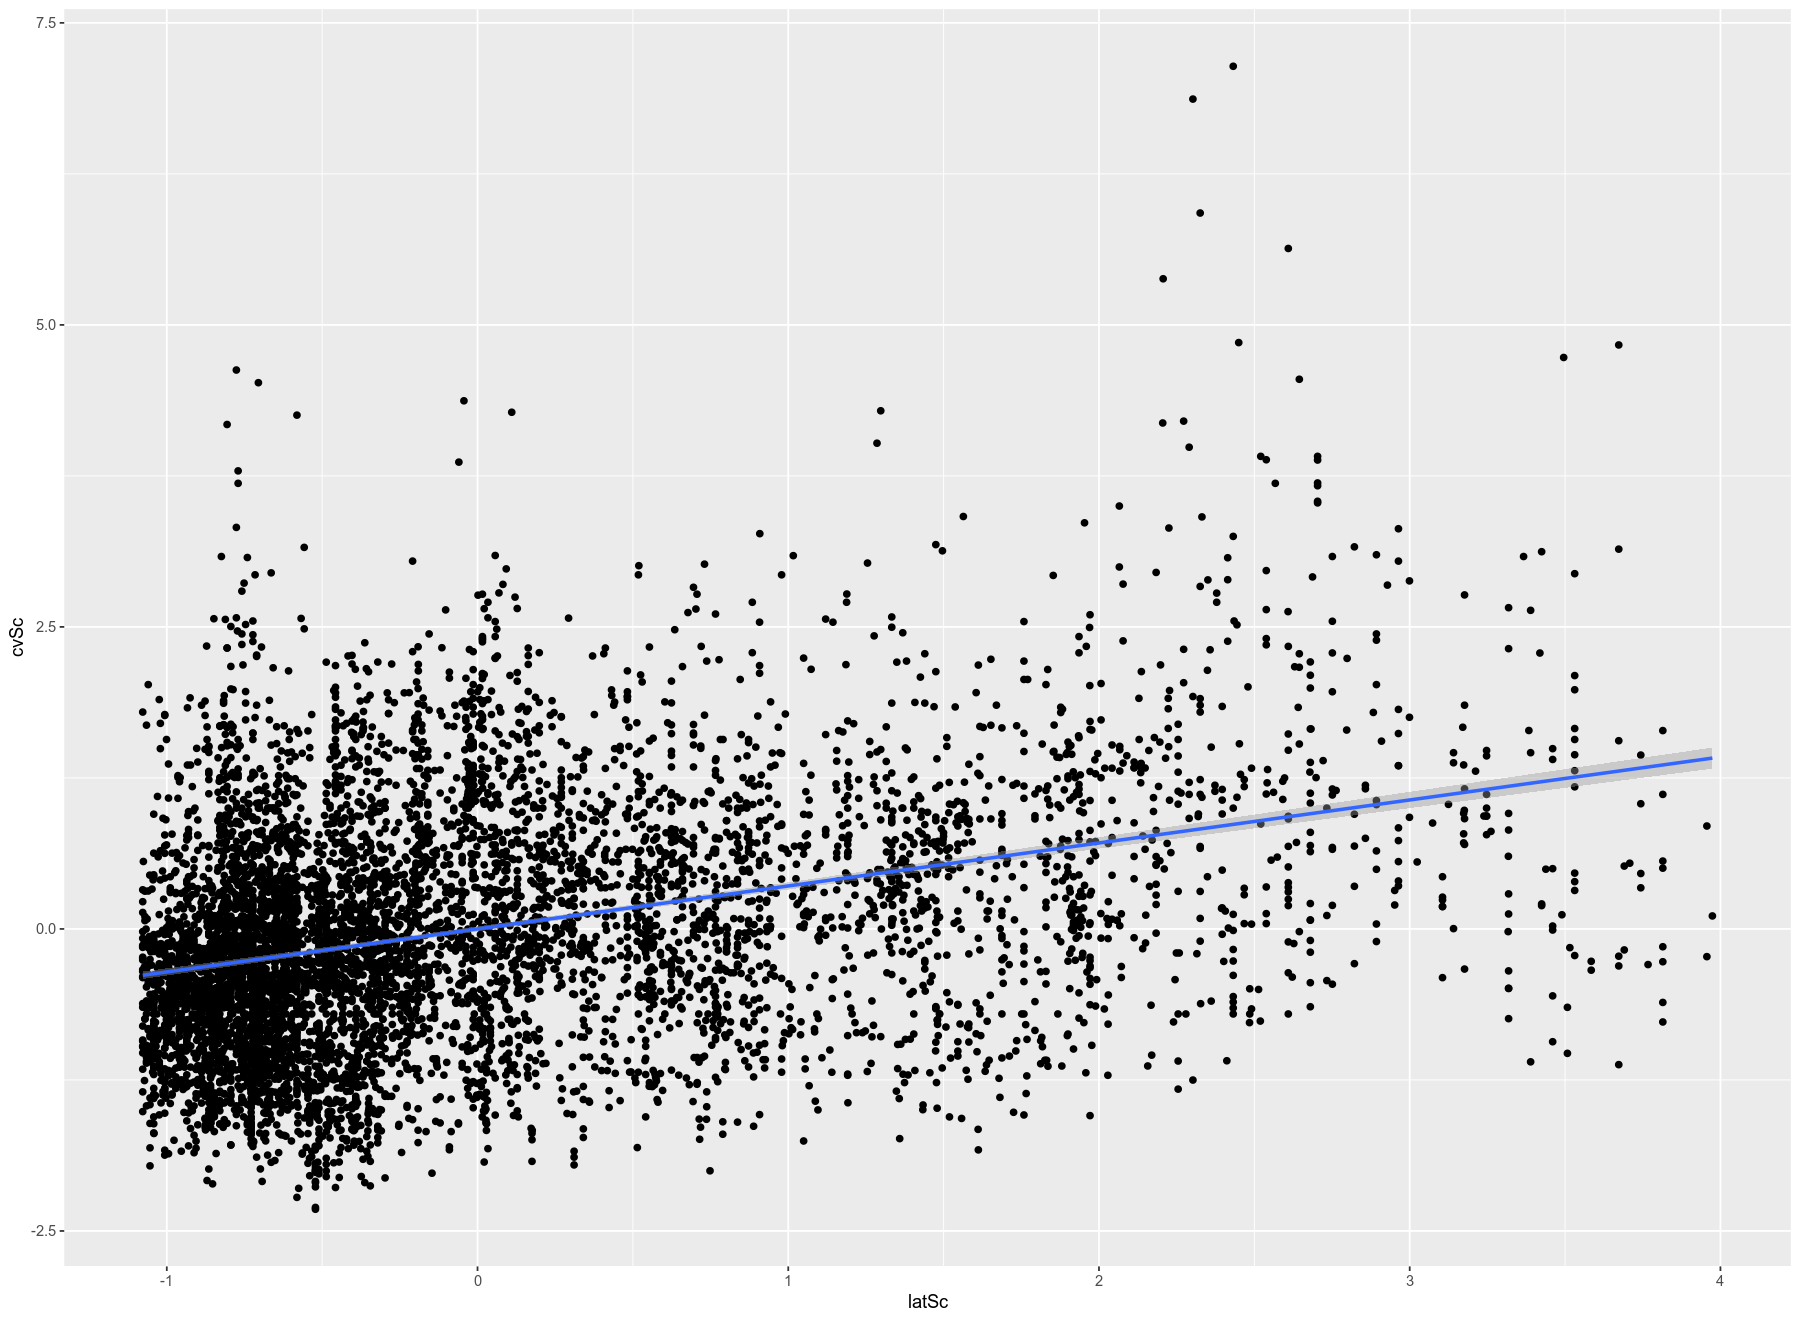

In [17]:
d1 %>%
    ggplot(aes(x = latSc, y = cvSc)) + 
    geom_point() + 
    geom_smooth(method='lm')

## Ordinary linear regression

In [18]:
cvlat.lm <- lm(cvSc ~ latSc, data = d1)
summary(cvlat.lm)


Call:
lm(formula = cvSc ~ latSc, data = d1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4303 -0.6185 -0.0694  0.5104  6.2752 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.203e-17  1.084e-02    0.00        1    
latSc       3.558e-01  1.084e-02   32.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9346 on 7429 degrees of freedom
Multiple R-squared:  0.1266,	Adjusted R-squared:  0.1265 
F-statistic:  1077 on 1 and 7429 DF,  p-value: < 2.2e-16


In [19]:
cv_nb1000 <- dnearneigh(coor.cv, 0, 1000, longlat=T)
cv_lw1000 <- nb2listw(cv_nb1000, style="W", zero.policy = T)

## Lagged-X model

In [20]:
cvlat.slx <- lmSLX(cvSc ~ latSc, data = d1, listw = cv_lw1000, zero.policy = T)
summary(cvlat.slx)

Warning message in lmSLX(cvSc ~ latSc, data = d1, listw = cv_lw1000, zero.policy = T):
“install the spatialreg package”Warning message in create_WX(x, listw, zero.policy = zero.policy, prefix = prefix):
“install the spatialreg package”


Call:
lm(formula = formula(paste("y ~ ", paste(colnames(x)[-1], collapse = "+"))), 
    data = as.data.frame(x), weights = weights)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3982 -0.6252 -0.0714  0.5139  6.2785 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.004889   0.010878   0.449    0.653    
latSc       0.005874   0.076301   0.077    0.939    
lag.latSc   0.362510   0.078237   4.633 3.66e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9333 on 7428 degrees of freedom
Multiple R-squared:  0.1291,	Adjusted R-squared:  0.1289 
F-statistic: 550.7 on 2 and 7428 DF,  p-value: < 2.2e-16


## Spatial autoregressive model

In [21]:
cvlat.sar <- spatialreg::lagsarlm(cvSc ~ latSc, data = d1, listw = cv_lw1000, zero.policy = T)
summary(cvlat.sar)


Call:
spatialreg::lagsarlm(formula = cvSc ~ latSc, data = d1, listw = cv_lw1000, 
    zero.policy = T)

Residuals:
      Min        1Q    Median        3Q       Max 
-2.907791 -0.529428 -0.069233  0.434494  5.202644 

Type: lag 
Regions with no neighbours included:
 5519 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value  Pr(>|z|)
(Intercept) 0.0031403  0.0094904  0.3309 0.7407283
latSc       0.0407541  0.0109092  3.7358 0.0001871

Rho: 0.90364, LR test value: 1857.5, p-value: < 2.22e-16
Asymptotic standard error: 0.0145
    z-value: 62.321, p-value: < 2.22e-16
Wald statistic: 3883.9, p-value: < 2.22e-16

Log likelihood: -9111.87 for lag model
ML residual variance (sigma squared): 0.66907, (sigma: 0.81797)
Number of observations: 7431 
Number of parameters estimated: 4 
AIC: 18232, (AIC for lm: 20087)
LM test for residual autocorrelation
test value: 2.2818, p-value: 0.1309


In [22]:
moran.test(residuals(cvlat.sar), cv_lw1000, zero.policy = T)


	Moran I test under randomisation

data:  residuals(cvlat.sar)  
weights: cv_lw1000  n reduced by no-neighbour observations
  

Moran I statistic standard deviate = 1.0325, p-value = 0.1509
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     1.545344e-03     -1.346076e-04      2.647342e-06 


## Spatial error model

In [23]:
cvlat.sem <- spatialreg::errorsarlm(cvSc ~ latSc, data = d1, listw = cv_lw1000, zero.policy = T)
summary(cvlat.sem)


Call:
spatialreg::errorsarlm(formula = cvSc ~ latSc, data = d1, listw = cv_lw1000, 
    zero.policy = T)

Residuals:
      Min        1Q    Median        3Q       Max 
-2.858766 -0.524857 -0.065899  0.438030  5.204130 

Type: error 
Regions with no neighbours included:
 5519 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value  Pr(>|z|)
(Intercept) -0.031339   0.107164 -0.2924      0.77
latSc        0.277890   0.054558  5.0935 3.515e-07

Lambda: 0.91204, LR test value: 1867.1, p-value: < 2.22e-16
Asymptotic standard error: 0.013669
    z-value: 66.723, p-value: < 2.22e-16
Wald statistic: 4451.9, p-value: < 2.22e-16

Log likelihood: -9107.07 for error model
ML residual variance (sigma squared): 0.66776, (sigma: 0.81717)
Number of observations: 7431 
Number of parameters estimated: 4 
AIC: 18222, (AIC for lm: 20087)


In [24]:
moran.test(residuals(cvlat.sem), cv_lw1000, zero.policy = T)


	Moran I test under randomisation

data:  residuals(cvlat.sem)  
weights: cv_lw1000  n reduced by no-neighbour observations
  

Moran I statistic standard deviate = 0.37484, p-value = 0.3539
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     4.752748e-04     -1.346076e-04      2.647341e-06 


## Model comparison

In [25]:
AIC(cvlat.lm, cvlat.slx, cvlat.sar, cvlat.sem) %>%
    mutate(deltaAIC = AIC - min(AIC)) %>%
    arrange(deltaAIC)

df AIC      deltaAIC   
cvlat.sem 4  18222.14    0.000000
cvlat.sar 4  18231.74    9.599415
cvlat.slx 4  20067.79 1845.649869
cvlat.lm  3  20087.24 1865.096555

## Theory: What exactly *is* spatial regression?

A statistical test is always based on probabilistic models of the data generating process. Ultimately, it is tested whether models are consistent with reality. So what are the models involved here?

Let us look again at ordinary linear regression:

$$
\begin{aligned}
    Y &= X\beta + \varepsilon
\end{aligned}
$$

Here it is assumed that $\varepsilon$ is a vector of *normally distributed* random variables which are mutually independent and have the same standard deviation - let's say $\sigma$:

$$
\varepsilon \sim \mathcal N(0, \sigma^2\mathbf{I})
$$

This is equivalent to saying that $Y$ (the vector of responses) is a random variable which is drawn from a *multivariate normal distribution*:

$$
Y \sim \mathcal{N}(X\beta, \sigma^2\mathbf{I})
$$

This in turn means that the likelihood of an observation vector $Y$, conditional on the control variables $X$, is given by the formula

$$
\mathcal{L}(Y|X; \beta, \sigma) = (2\pi\sigma^2)^{-\frac{N}{2}} e^{-\frac{(Y-X\beta)^T(Y-X\beta)}{2\sigma^2}}
$$

*Fitting a model* (in frequentist statistics) amounts to finding the values of $\beta, \sigma$ that maximize this likelihood.

The SAR model is similar, but it includes the spatial lag as additional covariate. So the formula is

$$
Y = X\beta + \rho WY + \varepsilon,
$$

where $W$ the the neighborhood weight matrix, and $\rho$ the strength of the spatial influence. To turn this into a probability distribution, we need some linear algebra:

$$
\begin{aligned}
Y &= X\beta + \rho WY + \varepsilon\\
\mathbf{I}Y &= X\beta + \rho WY + \varepsilon\\
(\mathbf{I} - \rho W)Y &= X\beta + \varepsilon\\
Y &= (\mathbf{I} - \rho W)^{-1}X\beta + (\mathbf{I} - \rho W)^{-1}\varepsilon
\end{aligned}
$$

This entails that $Y$ is distributed according to the following multivariate normal distribution:

$$
Y \sim \mathcal{N}(\mathbf{I} - \rho W)^{-1}X\beta, \sigma^2(\mathbf{I} - \rho \rho W)^{-1}((\mathbf{I} - \rho W)^{-1})^T)
$$



The important thing to notice is the variance-covariance matrix

$$
(\mathbf{I} - \rho W)^{-1}((\mathbf{I} - \rho W)^{-1})^T
$$
which replaces the identity matrix $\mathbf{I}$ in ordinary regression.

So in SAR, the residuals are not assumed to be indepent. Rather, they are predicted to the correlated, and the correlation is expected to be stronger the closer two points are in space.

The *spatial error model* differs only slightly

$$
\begin{align}
Y &= X\beta + u\\
u &= \lambda W u + \varepsilon\\
u &= (\mathbf{I}-\lambda w)^{-1}\varepsilon
\end{align}
$$

In [26]:
cv_nb <- poly2nb(cvVoronoi, queen=TRUE)
cv_lw <- nb2listw(cv_nb, style="W", zero.policy = T)

In [27]:
rho = 0.91204

In [28]:
W = nb2mat(cv_nb1000, zero.policy = T)
A = -rho * W
diag(A) <- 1
Ainv = solve(A)
Sigma = Ainv %*% t(Ainv)

In [83]:
i = sample(nrow(Sigma), 1)

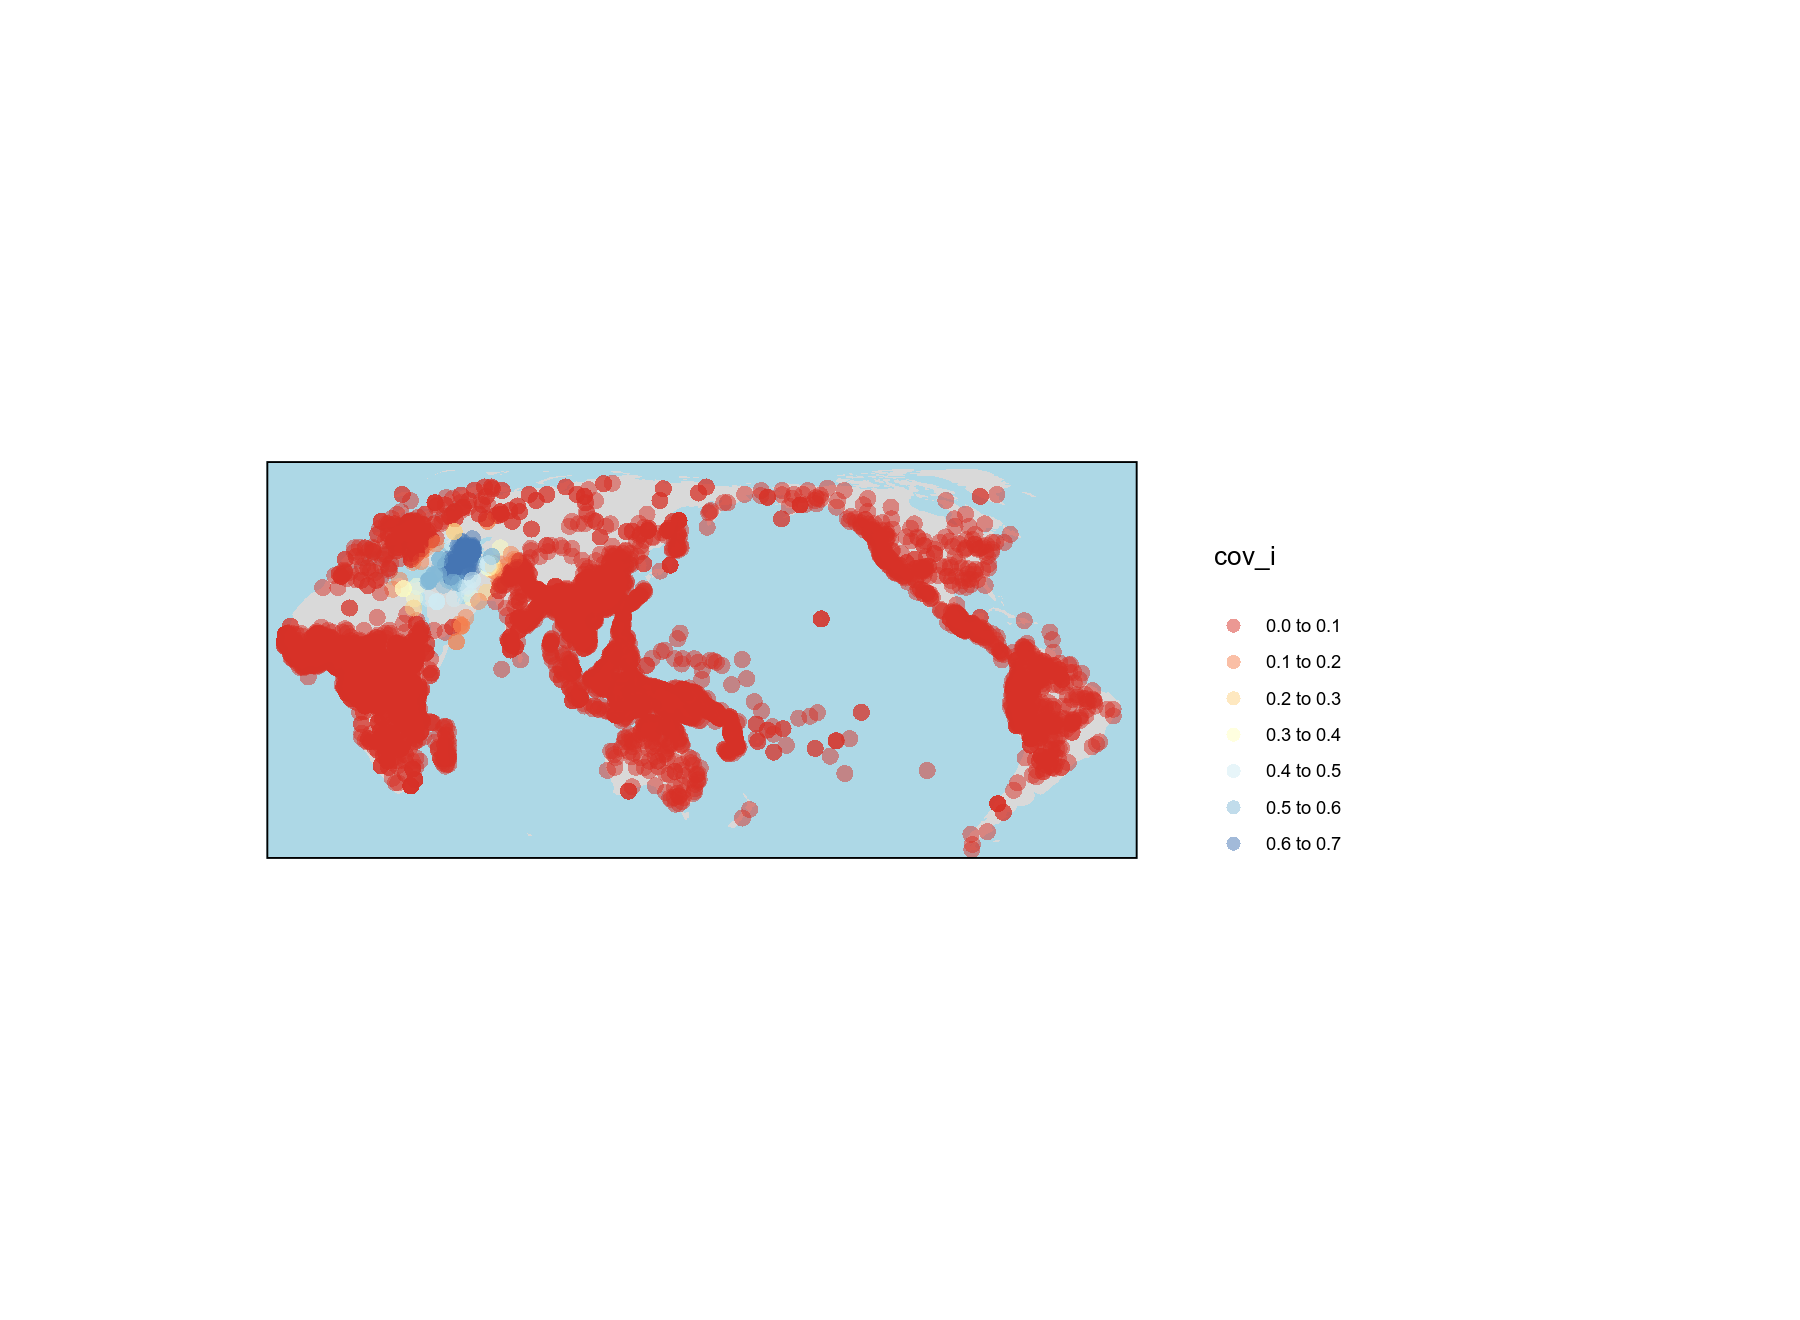

In [84]:
bg.map + (d1 %>%
    st_transform("+proj=eqearth lon_0=160") %>%
    mutate(cov_i = Sigma[i,]) %>%
    filter(Name != d1$Name[i]) %>%
    tm_shape() +
    tm_dots(col='cov_i', size=.1, border.lwd=0, palette = "RdYlBu", alpha=0.5, style="pretty") +
    tm_layout(legend.outside=T, bg.color = 'lightblue', scale=3))

In [31]:
d1 %>% 
    filter(Name == d1$Name[i]) %>%
    st_distance(d1) -> dists_i

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


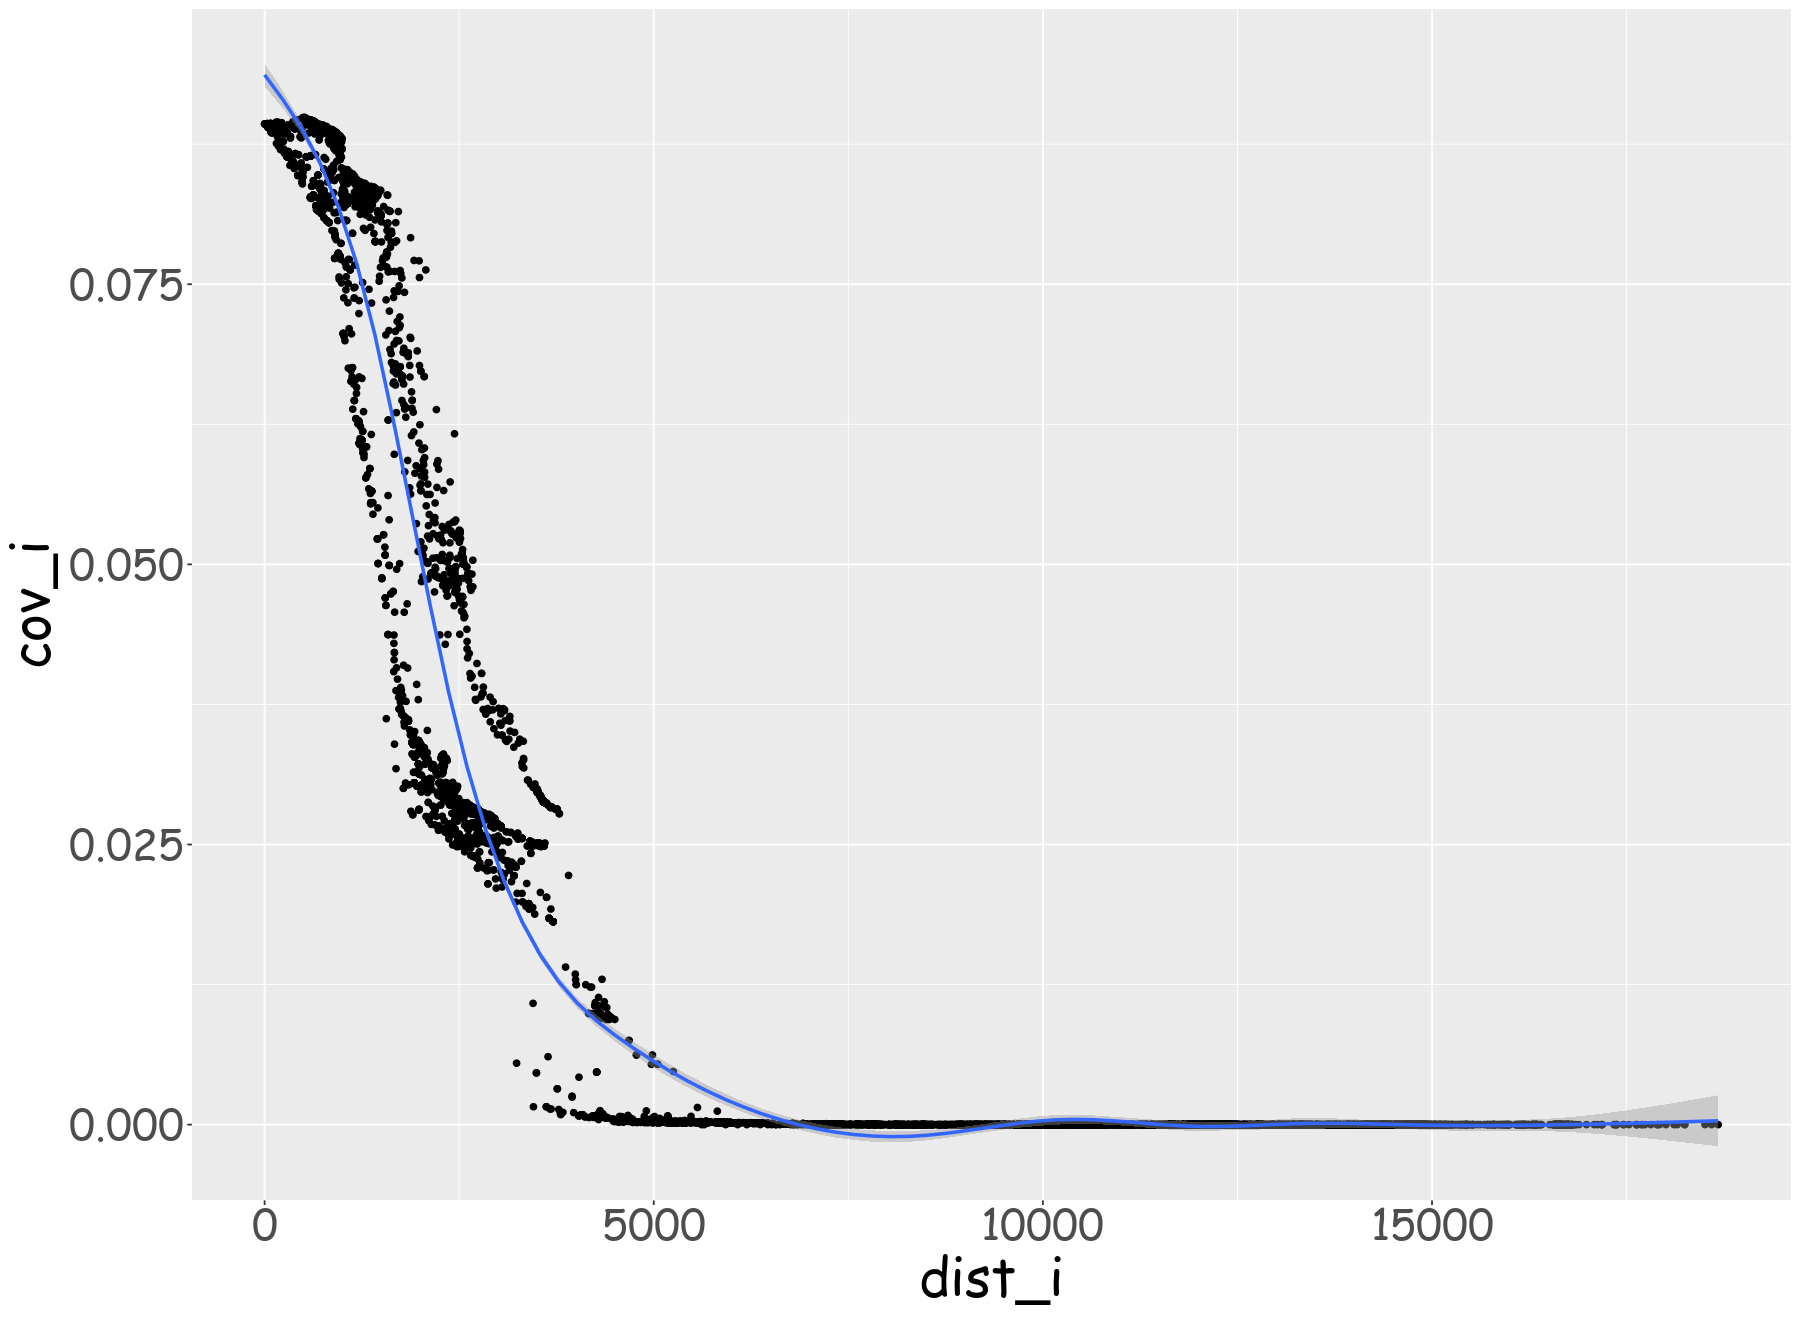

In [32]:
d1 %>%
    mutate(dist_i = c(as(dists_i, "matrix"))/1000) %>%
    mutate(cov_i = Sigma[i,]) %>%
    filter(Name != d1$Name[i]) %>%
    ggplot(aes(x=dist_i, y = cov_i)) +
    geom_point() +
    geom_smooth() +
    theme(text=element_text(size=32,  family="Comic Sans MS"))

# Spatial interpolation

So far we considered problems where there data are located at finite collection of points or areas in space.

Another family of geospatial models deals with processes where, in theory, variables have a value at every point within a certain area.

For instance, we can accept as an idealization that dialectal variation has a value at each point within a geographical area.

**Spatial interpolation** is the process of inferring values for each point based on a finite number of sample observations.

In [33]:
library(tmap)
library(terra)
library(gstat)
library(mgcv)

terra version 1.2.10
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.


In [34]:
pad_voronoi <- read_sf("data/pad_voronoi.shp")
germany <- pad_voronoi %>% 
    st_geometry() %>%
    st_union() 

although coordinates are longitude/latitude, st_union assumes that they are planar


In [35]:
pad_mds <- read_csv("data/pad_mds.csv") %>%
    st_as_sf(coords = c("LONGITUDE", "LATITUDE"))

st_crs(pad_mds) <- 4326


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  doculect = col_character(),
  LONGITUDE = col_double(),
  LATITUDE = col_double(),
  col = col_character(),
  r = col_double(),
  g = col_double(),
  b = col_double()
)



In [36]:
pad_grid <- germany %>% 
    st_bbox() %>%
    st_as_sfc() %>%
    st_make_grid(
        cellsize = c(.05, .05),
        what="centers"
    ) %>% 
    st_as_sf(crs=4326) 

## Inverse distance weighted interpolation

Inverse distance-based weighted interpolation (IDW) computes a weighted average of the values at the observed points to estimate the value at an unobserved point.

$$
\hat Z (s_0) = \frac{\sum_{i=1}^n ||s_i-s_0||^{-2}Z(s_i)}{\sum_{i=1}^n ||s_i-s_0||^{-2}}
$$

In [37]:
pad.idw <- idw(r ~ 1, location = pad_mds, newdata = pad_grid, idp=2)

[inverse distance weighted interpolation]


In [38]:
pad.idw.raster <- pad.idw %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = var1.pred) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

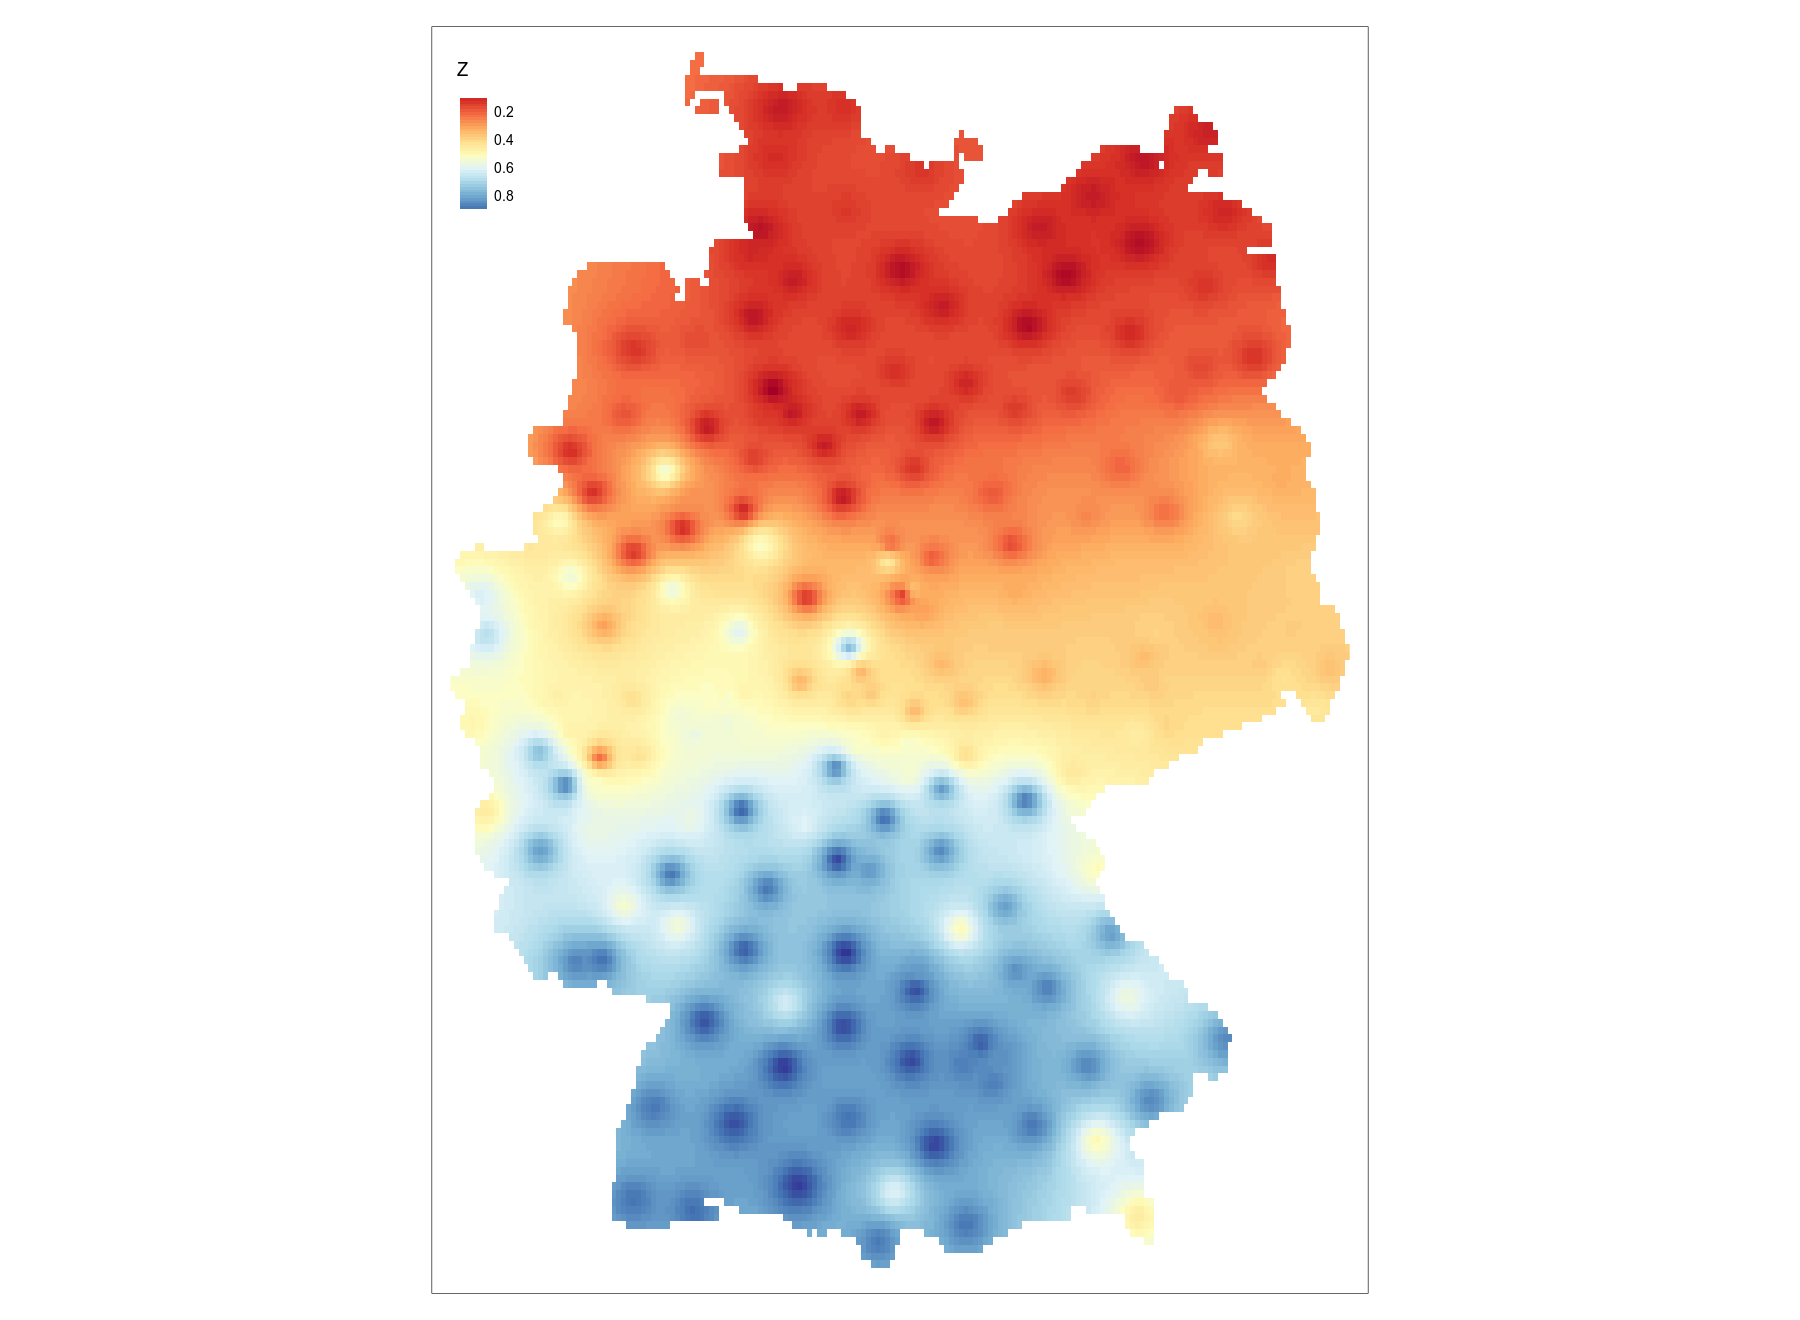

In [39]:
mask(pad.idw.raster, vect(germany)) %>%
    tm_shape() +
    tm_raster(style = "cont", palette = "RdYlBu", legend.show = TRUE)

## Ordinary Kriging

**Kriging** (named after Danie Gerhardus Krige, a South-African mining engineer and statistician) assumes that the data are generated by a *Gaussian Process*. 

This means that the value at each point is drawn from a normal distribution. The covariance between the values at two points is determined by a *kernel*, a monotonically decreasing function of the spatial distance.

Demo: https://www.tmpl.fi/gp/

<img src="https://img.search.brave.com/6thxhdjEVLM_3sBUNcfSp-kHHbe8OSLLMrSbpXERmZ4/rs:fit:800:600:1/g:ce/aHR0cDovL3NjaWtp/dC1sZWFybi5vcmcv/MC4xNy9faW1hZ2Vz/L3Bsb3RfZ3BfcmVn/cmVzc2lvbl8wMDEu/cG5n">


To apply Kriging, a decision about the kernel has to be made. Variograms are used as a heuristics.

In a variogram, squared differences are plotted against spatial distance. Note that (under stationarity):

$$
(Z_i-Z_j)^2 = 2(Var(Z_i) - Cov(Z_i, Z_j))
$$


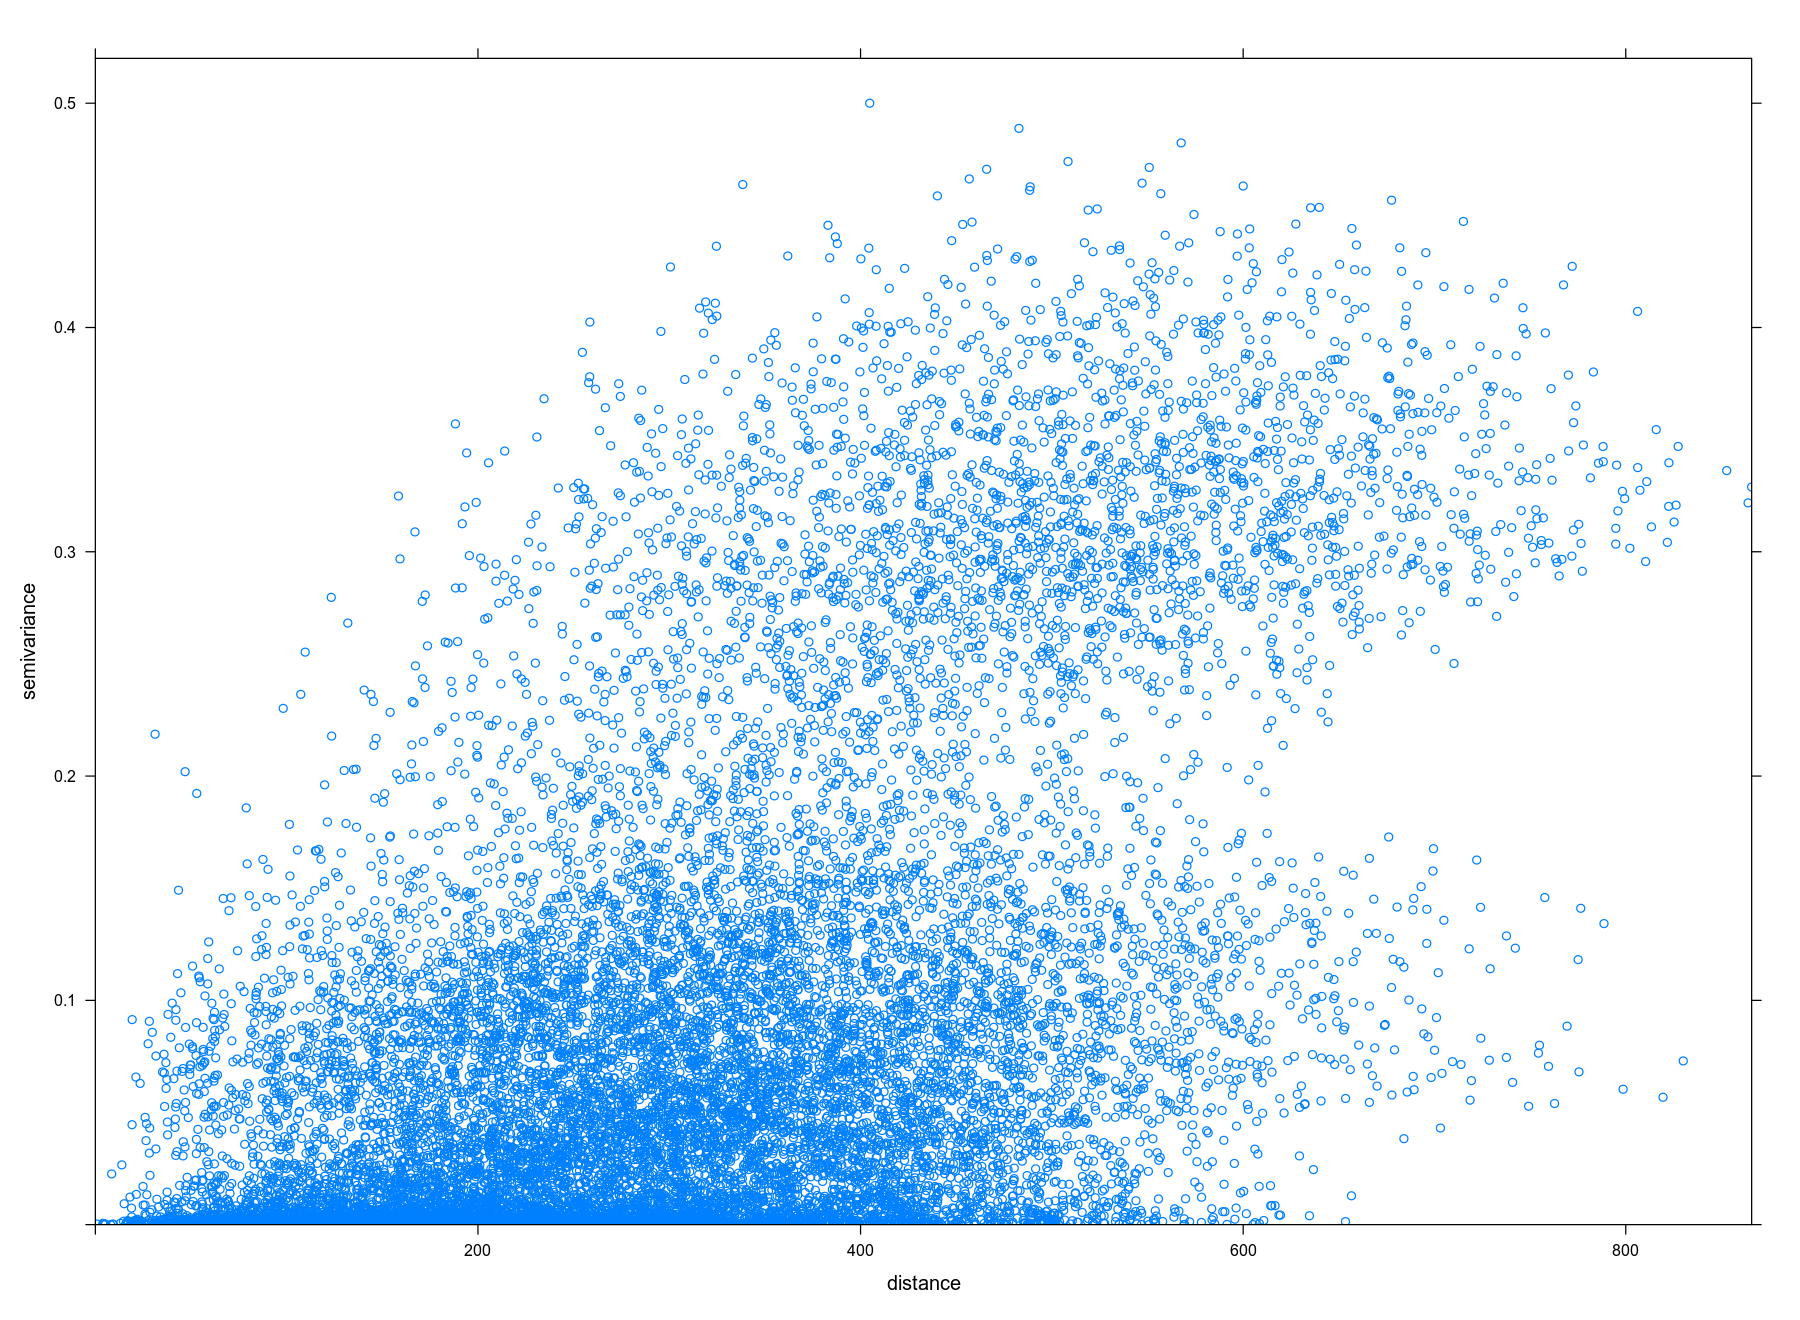

In [40]:
pad_mds %>% 
    variogram(r ~ 1, ., cloud=T, cutoff=1000) %>%
    plot()


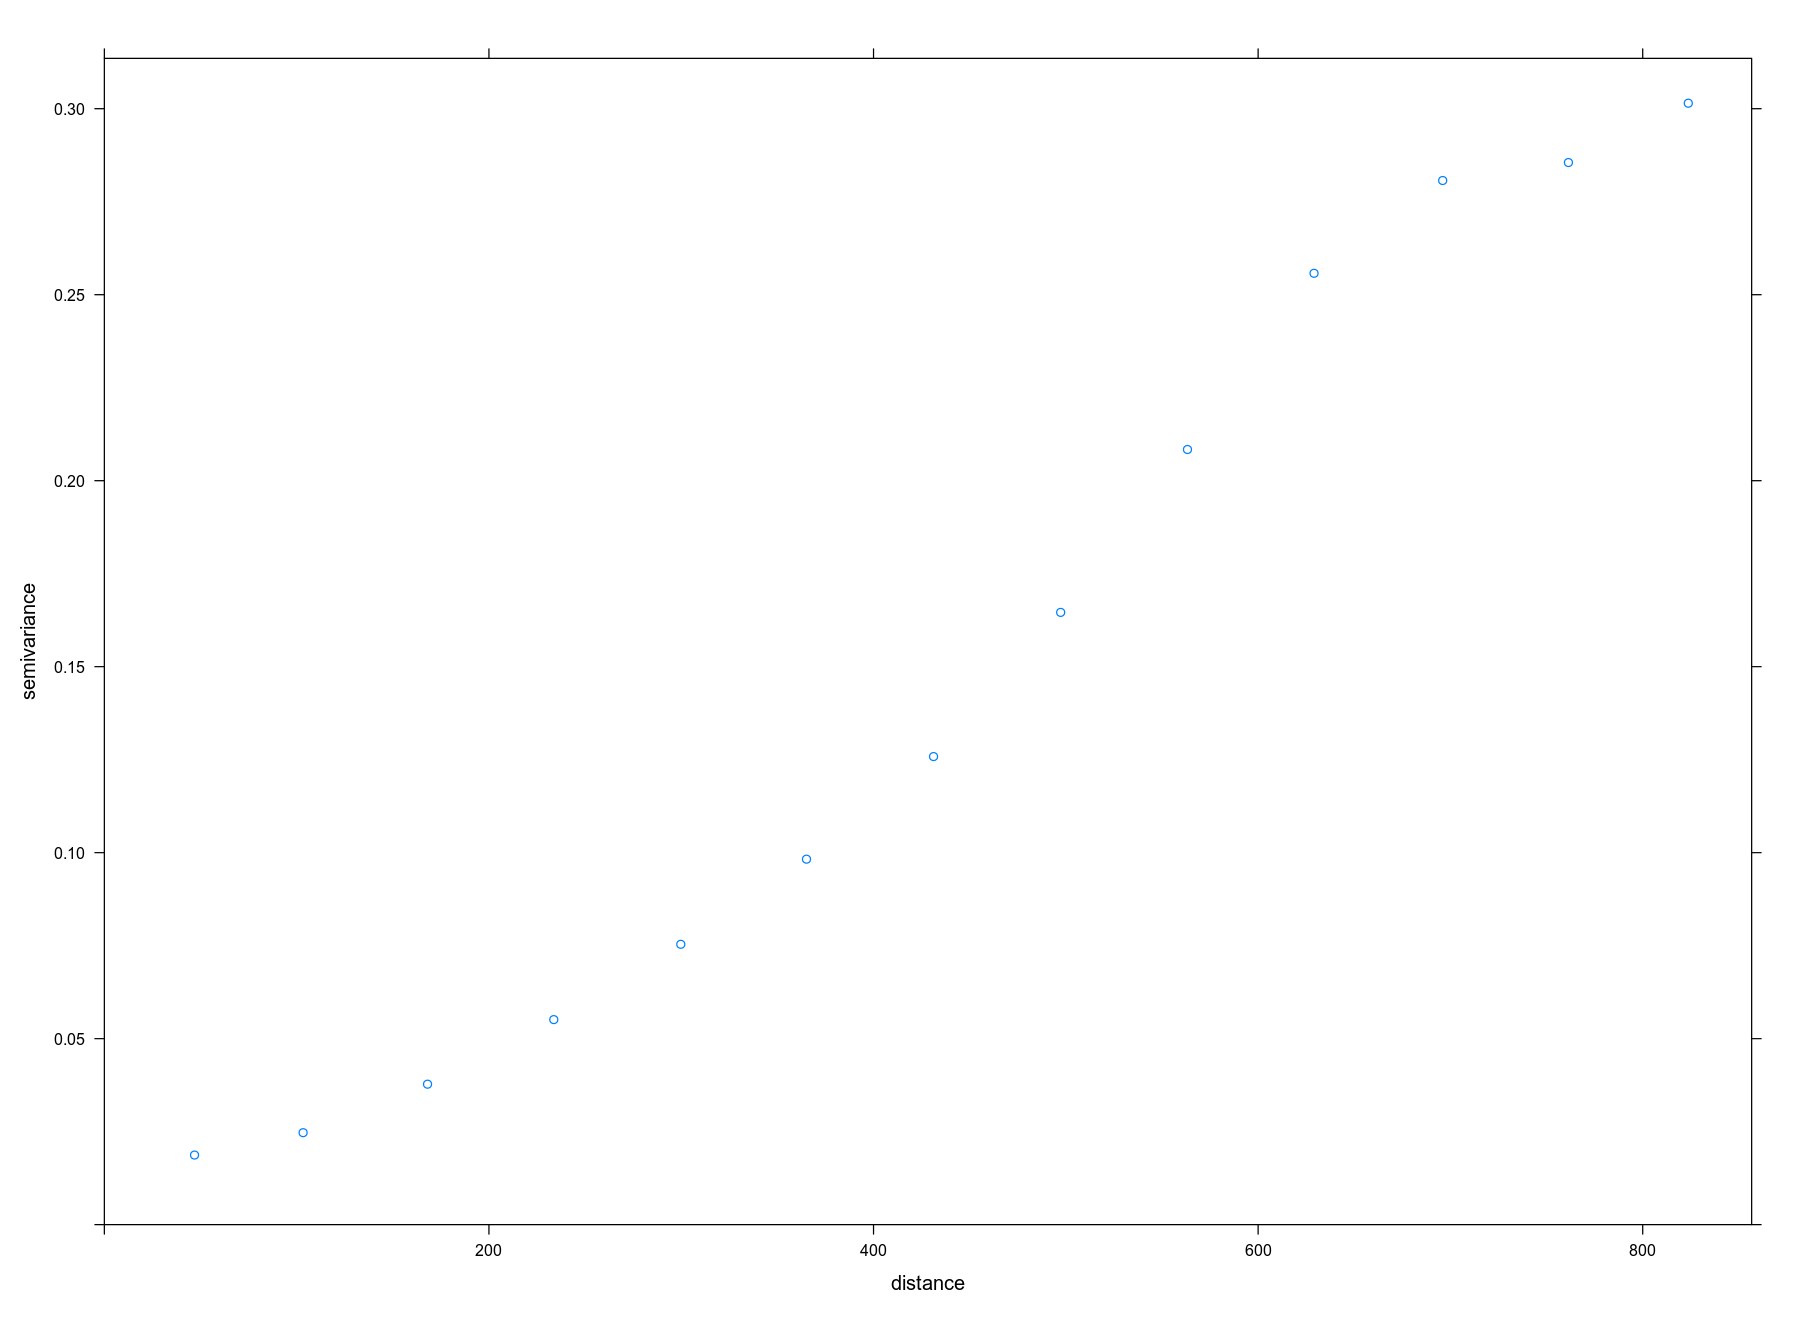

In [41]:
pad_mds %>% 
    variogram(r ~ 1, ., cloud=F, cutoff=1000) -> pad.v
pad.v %>% plot()

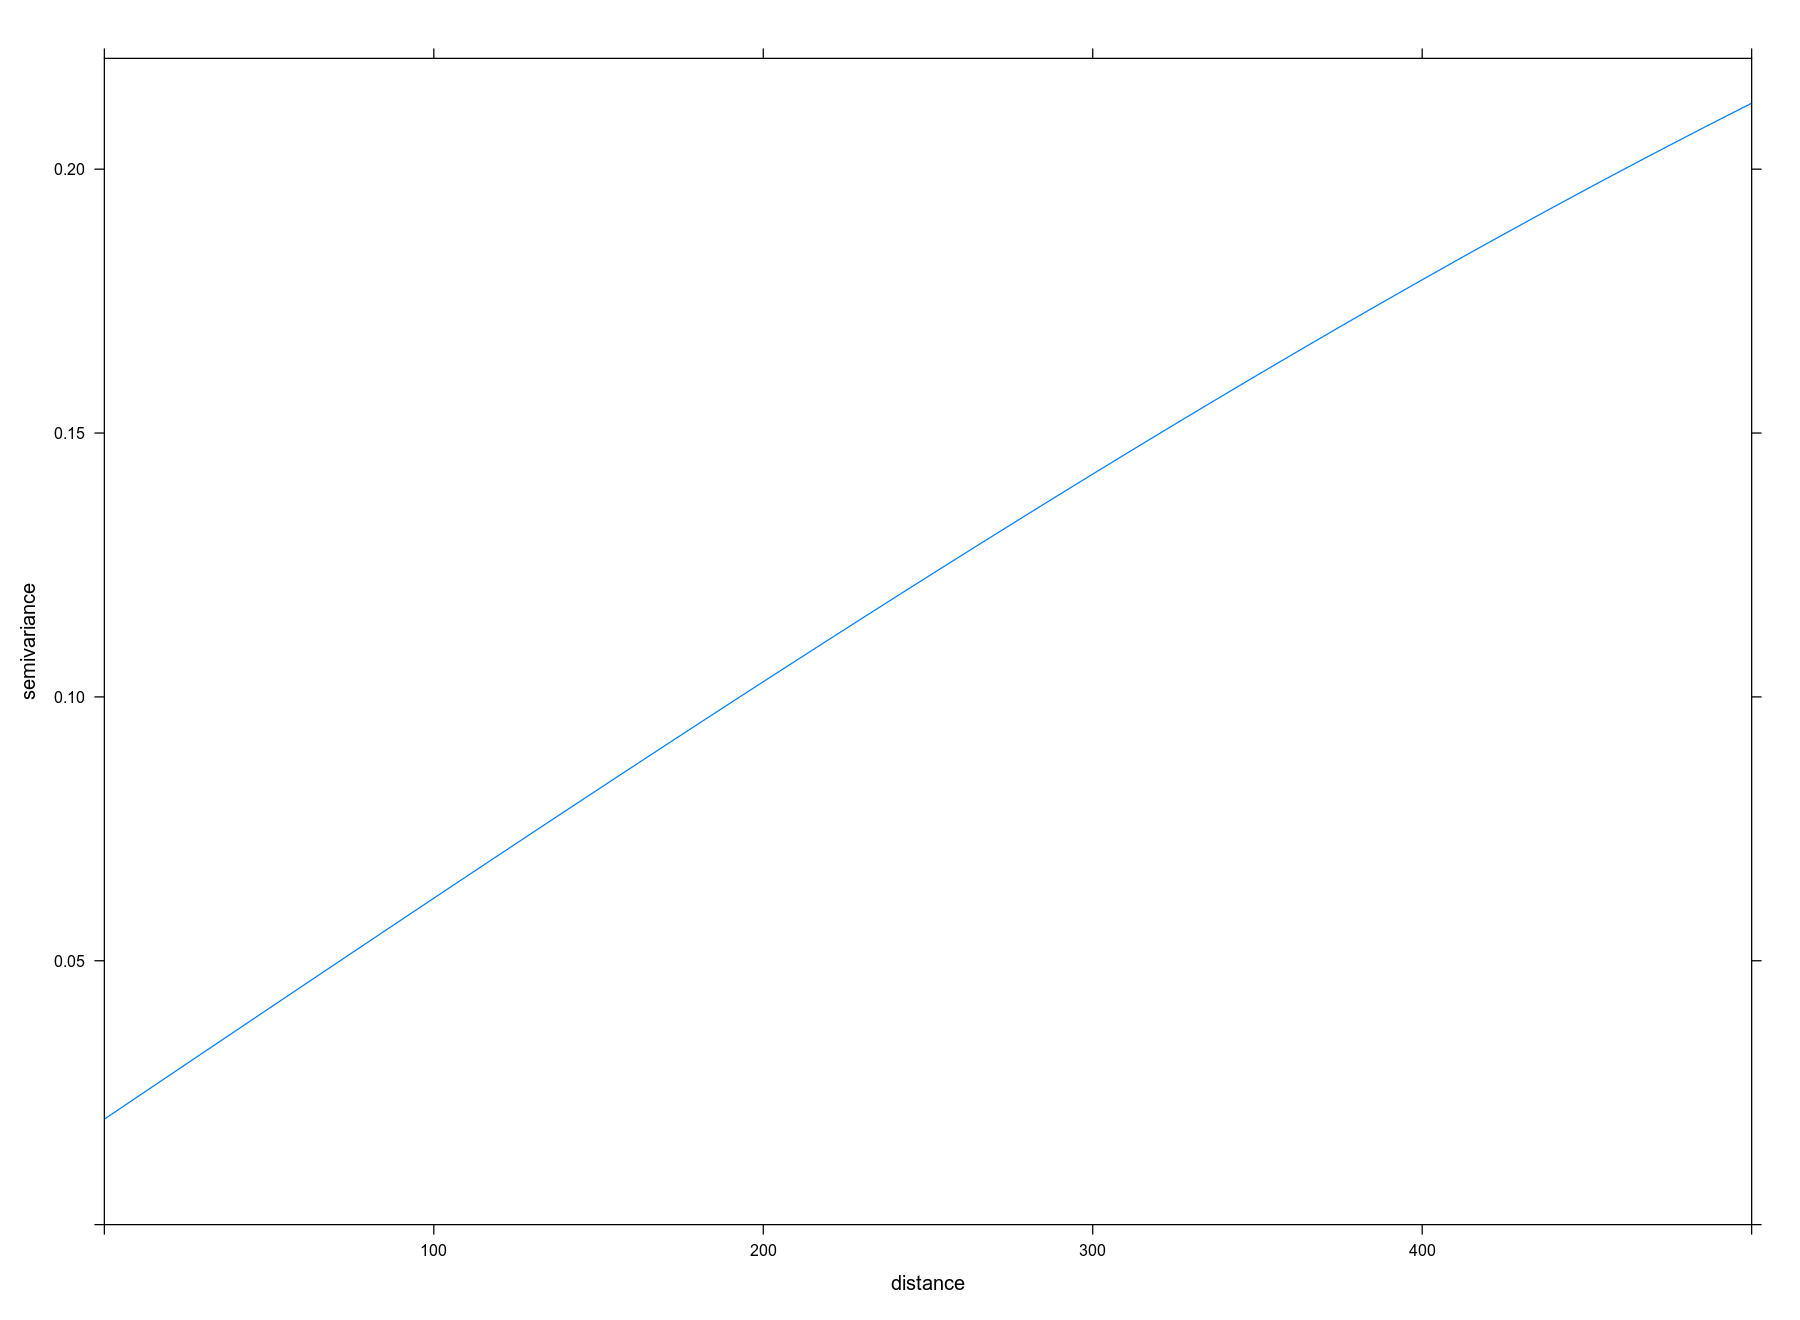

In [42]:
myVariogramModel <- vgm(psill=0.28, "Sph", range=1000, nugget=0.02)

plot(myVariogramModel, cutoff=500)

In [43]:
pad.vfit <- fit.variogram(pad.v, myVariogramModel, fit.ranges=F)


In [44]:
pad.krige <- krige(r ~ 1, pad_mds, pad_grid, pad.vfit)

[using ordinary kriging]


In [45]:
pad.krige.raster <- pad.krige %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = var1.pred) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

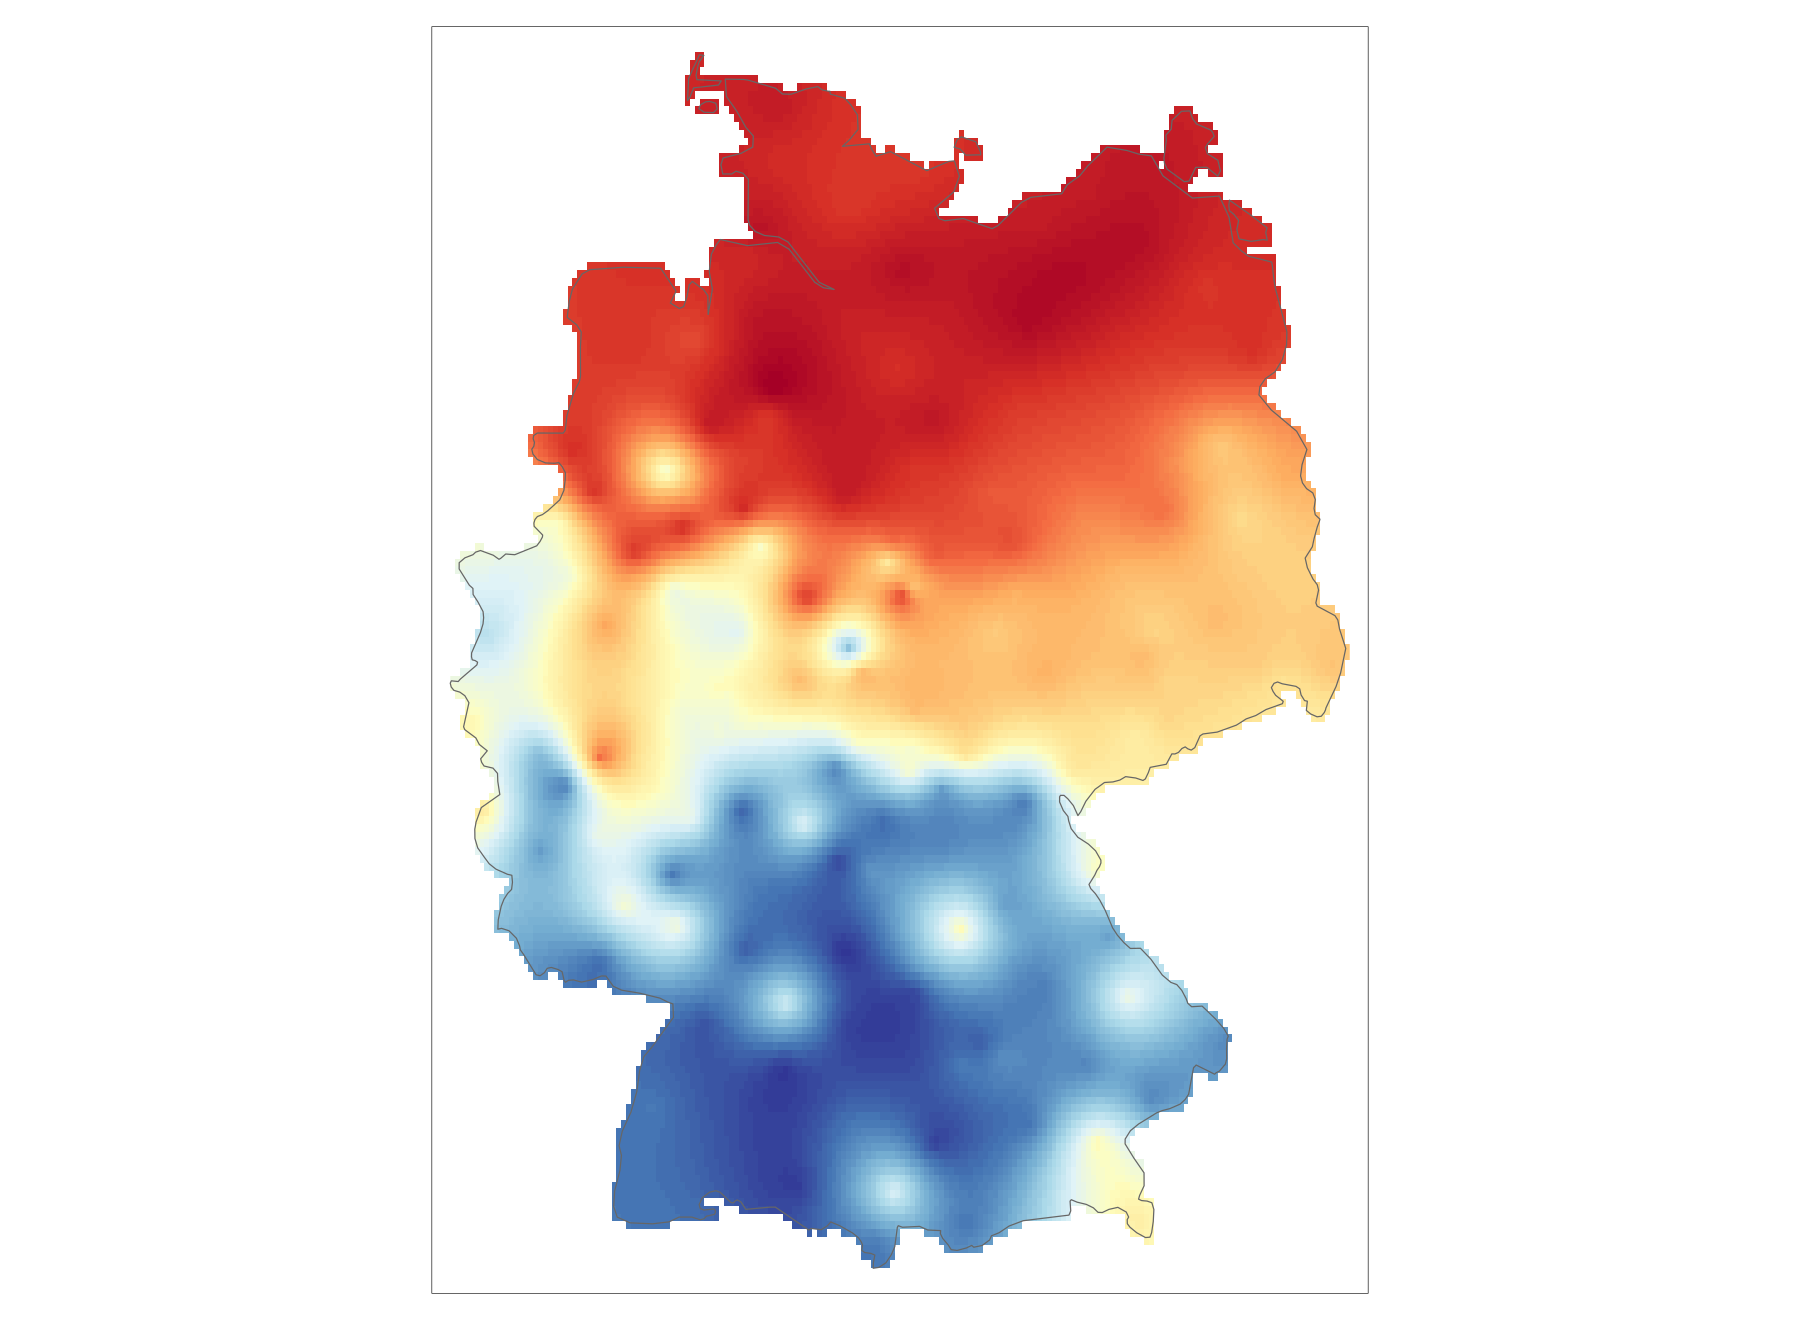

In [46]:
mask(pad.krige.raster, vect(germany)) %>%
    tm_shape() +
    tm_raster(palette = "RdYlBu", legend.show = F, style="cont") +
    tm_shape(st_sfc(germany)) +
    tm_borders()

## Generalized Additive Models


For a brief intuitive explanation, see https://towardsdatascience.com/generalised-additive-models-6dfbedf1350a

In [47]:
pad_mds %>%
    cbind(., st_coordinates(.)) %>%
    select(r, X, Y) %>%
    mgcv::gam(r ~ s(X,Y), data=.) -> gam.fit

In [48]:
gam.prediction <- predict(gam.fit, newdata = data.frame(st_coordinates(pad_grid)))

In [49]:
pad.gam <- pad.krige %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = gam.prediction) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

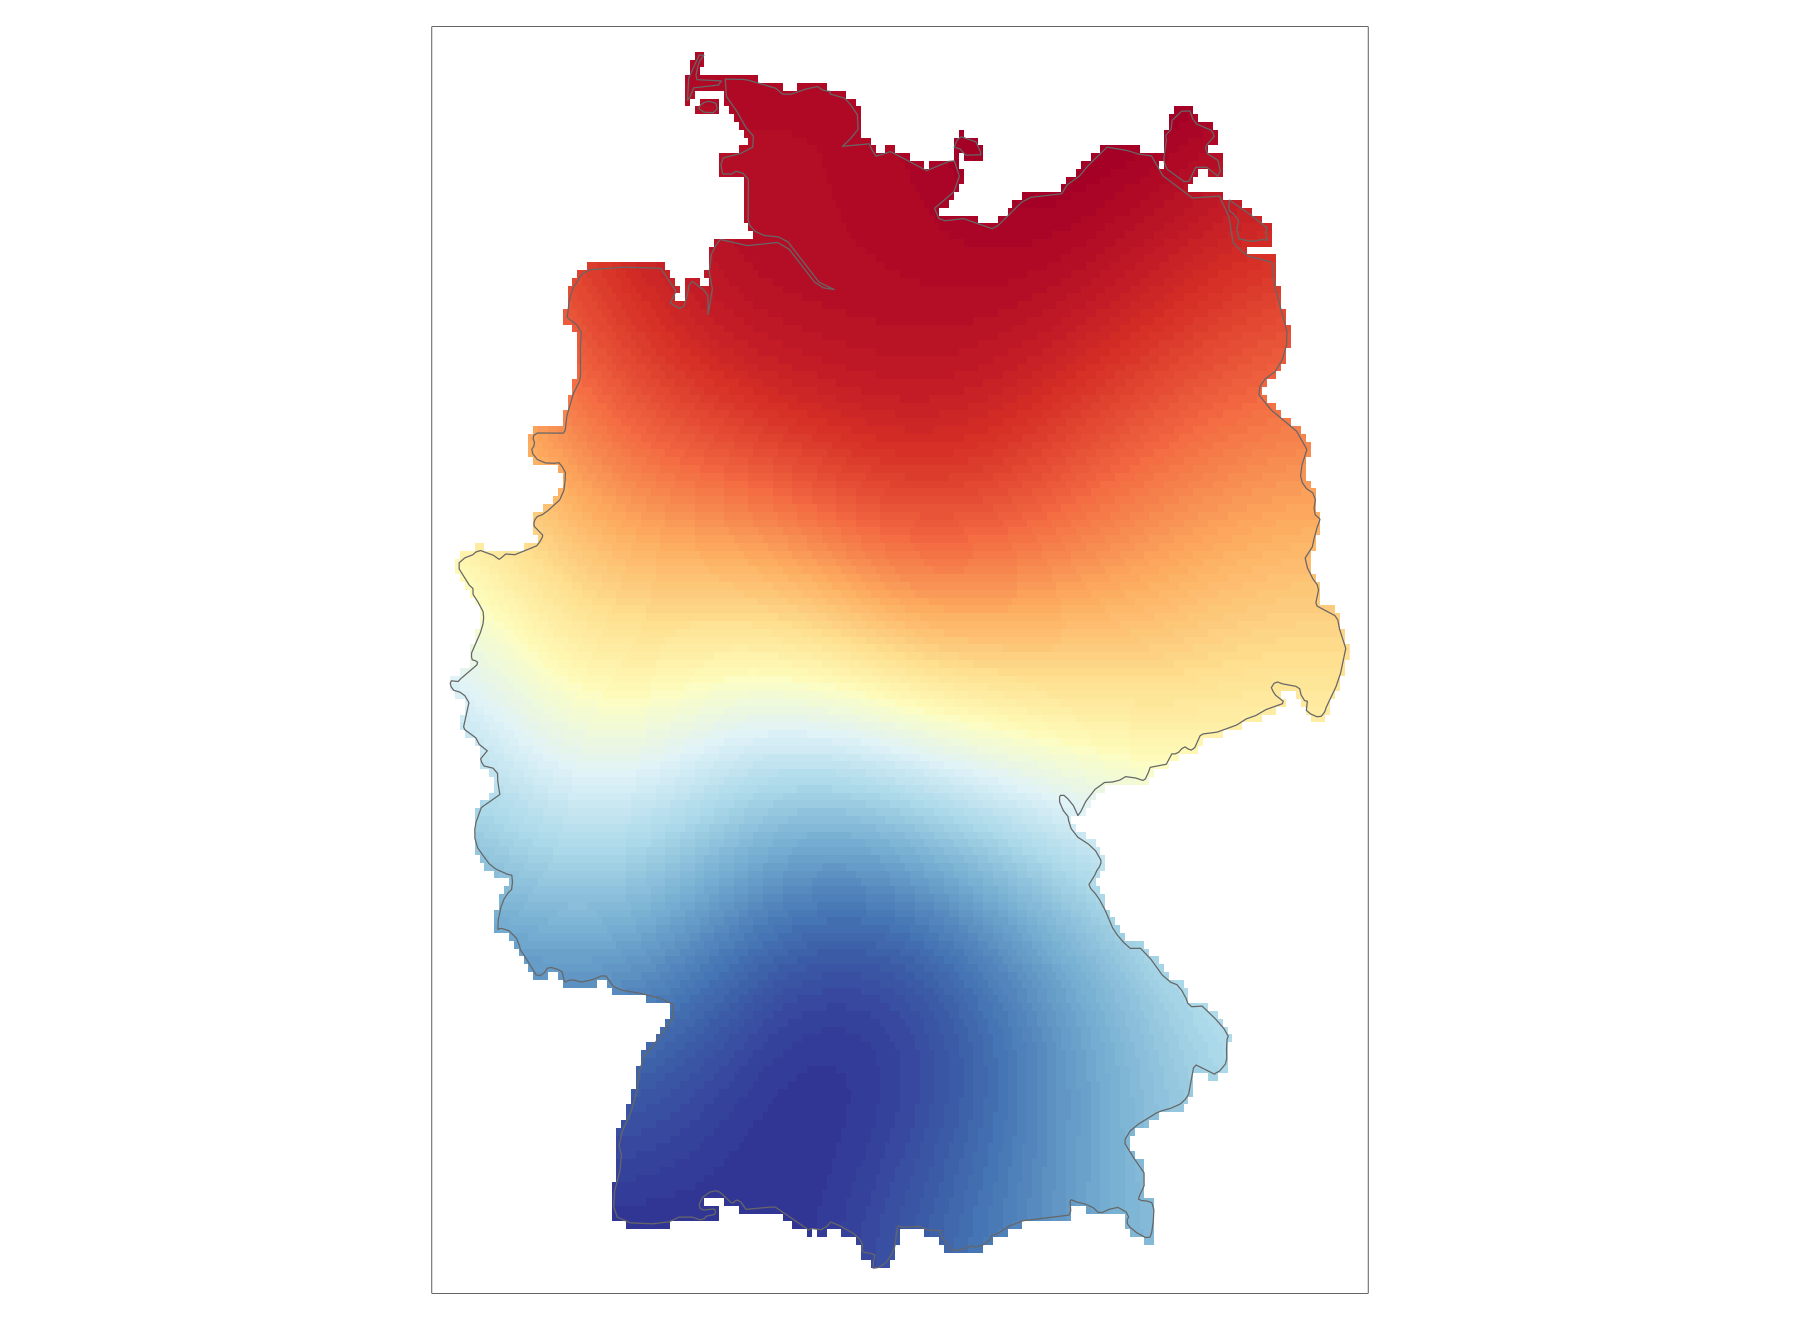

In [50]:
mask(pad.gam, vect(germany)) %>%
    tm_shape() +
    tm_raster(palette = "RdYlBu", legend.show = F, style="cont") +
    tm_shape(st_sfc(germany)) +
    tm_borders()

### Second dimension

In [51]:
pad.idw <- idw(g ~ 1, location = pad_mds, newdata = pad_grid, idp=2)

[inverse distance weighted interpolation]


In [52]:
pad.idw.raster <- pad.idw %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = var1.pred) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

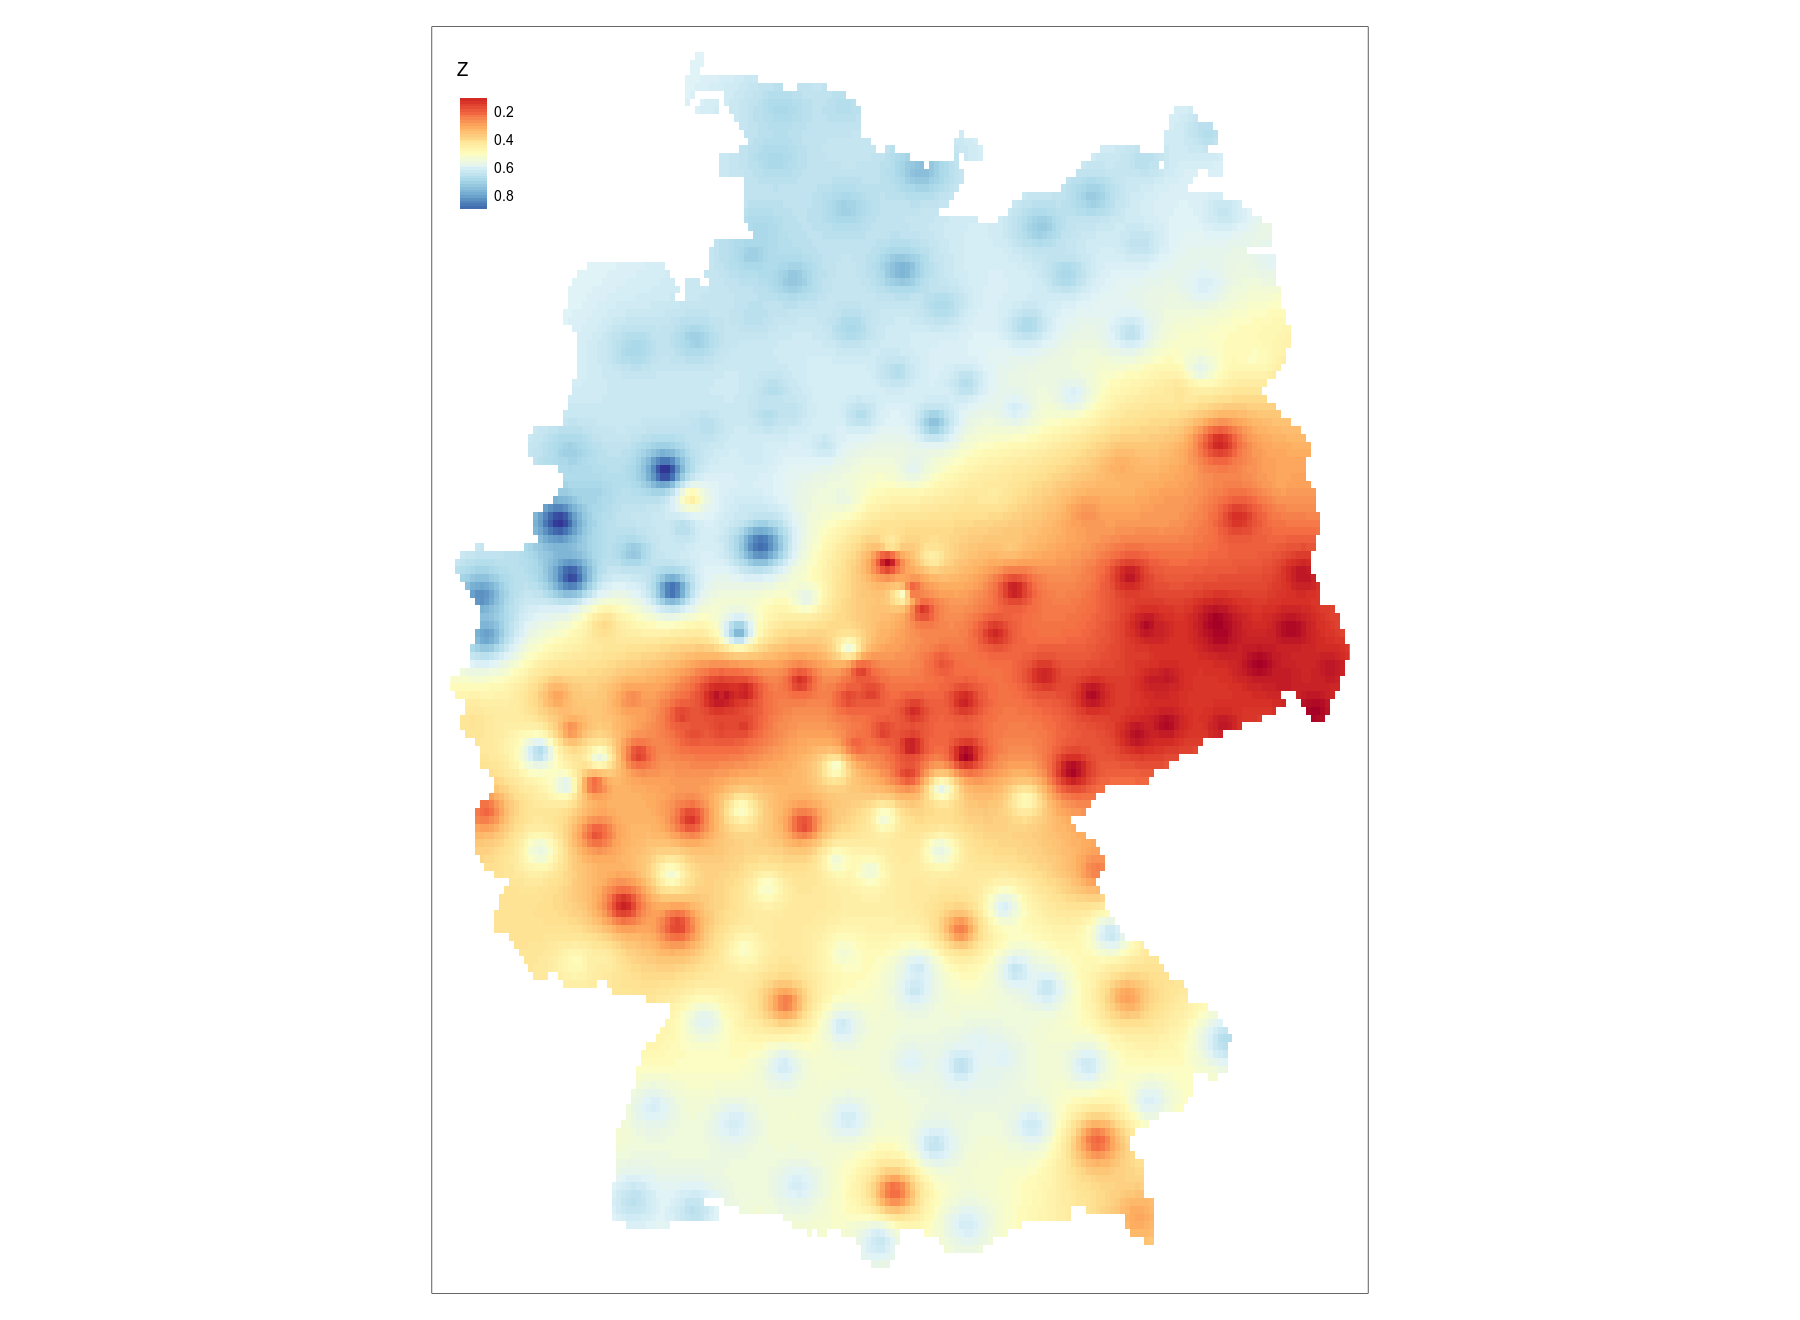

In [53]:
mask(pad.idw.raster, vect(germany)) %>%
    tm_shape() +
    tm_raster(style = "cont", palette = "RdYlBu", legend.show = TRUE)

## Ordinary Kriging

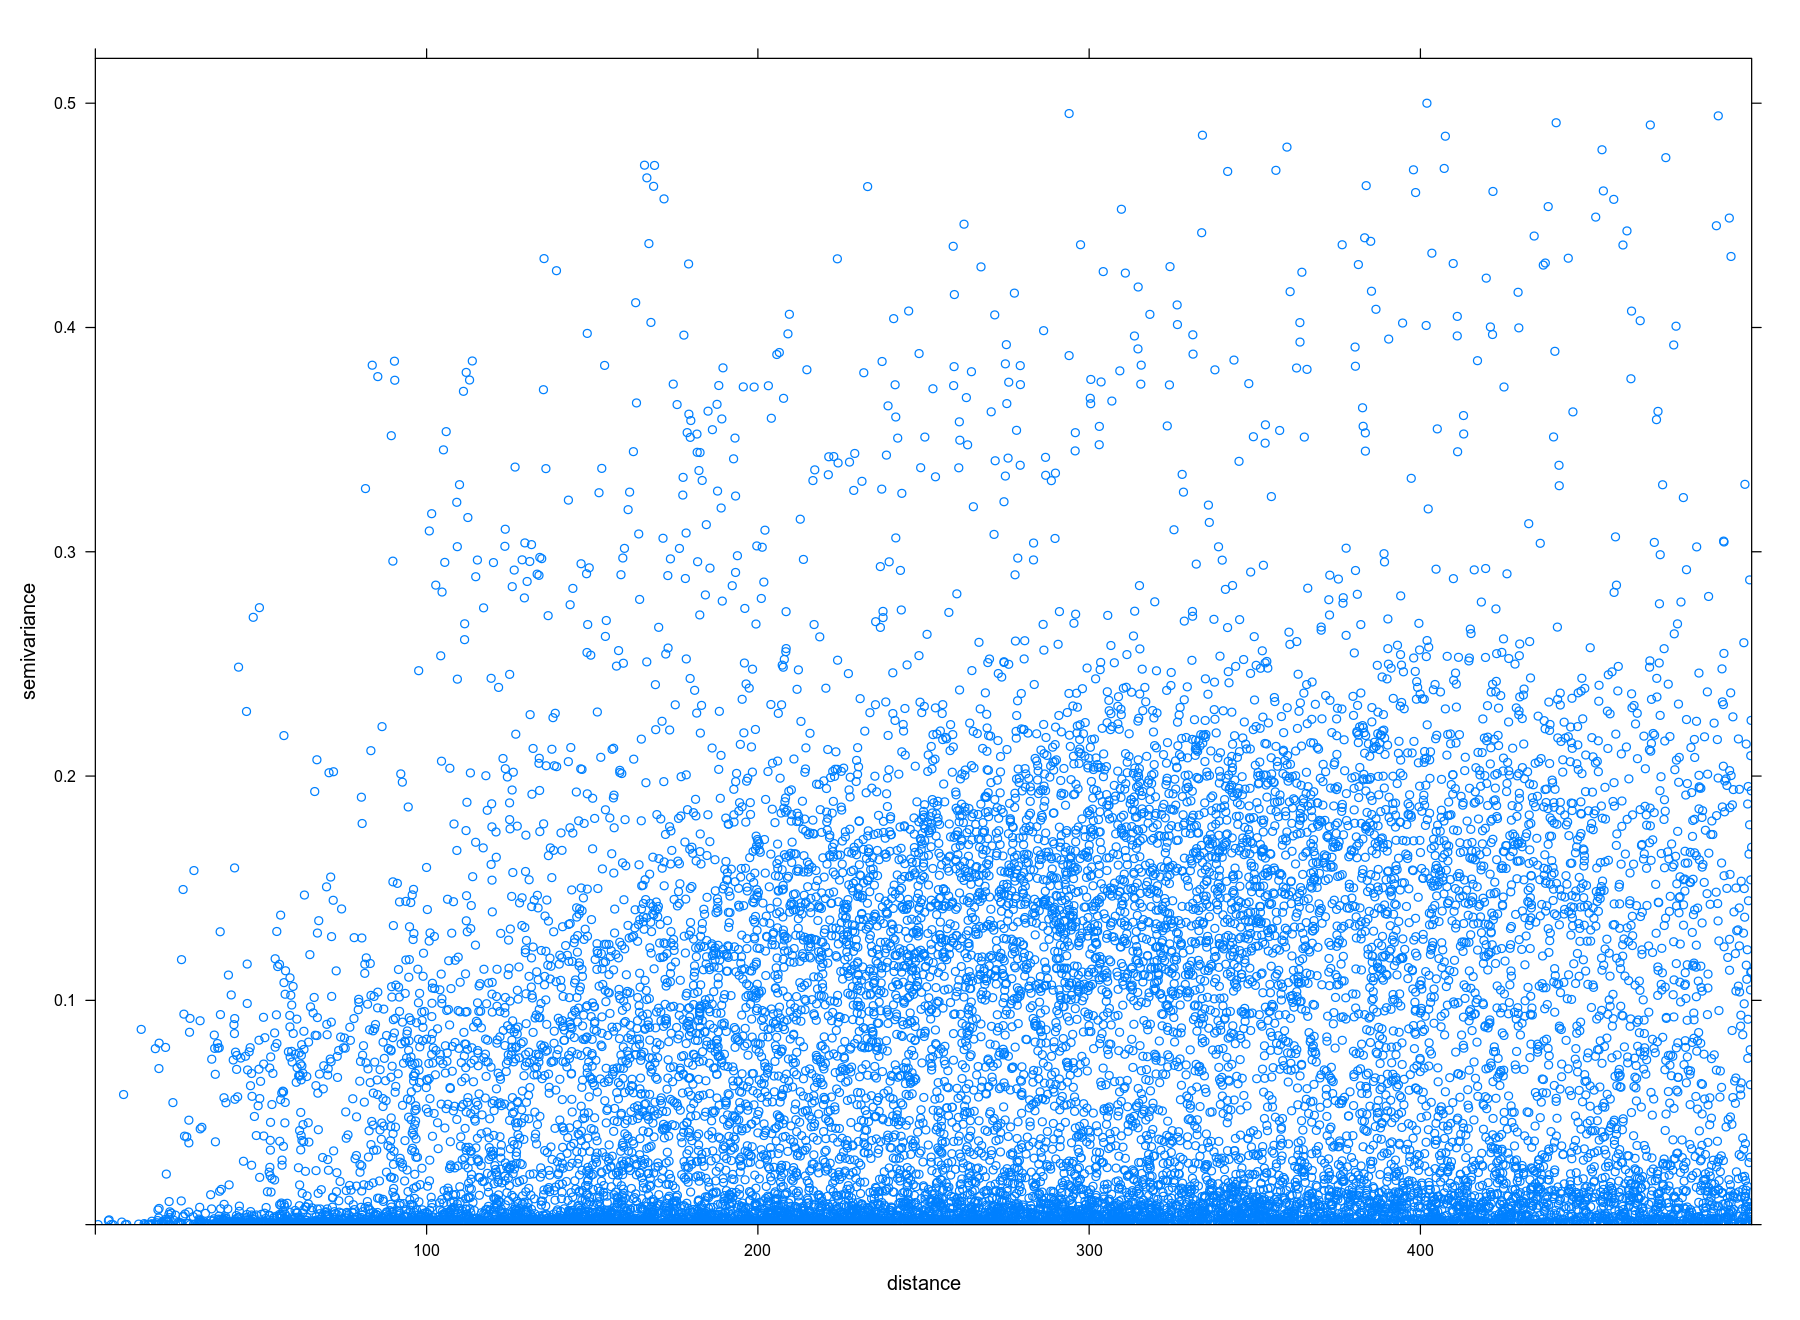

In [54]:
pad_mds %>% 
    variogram(g~ 1, ., cloud=T, cutoff=500) %>%
    plot()


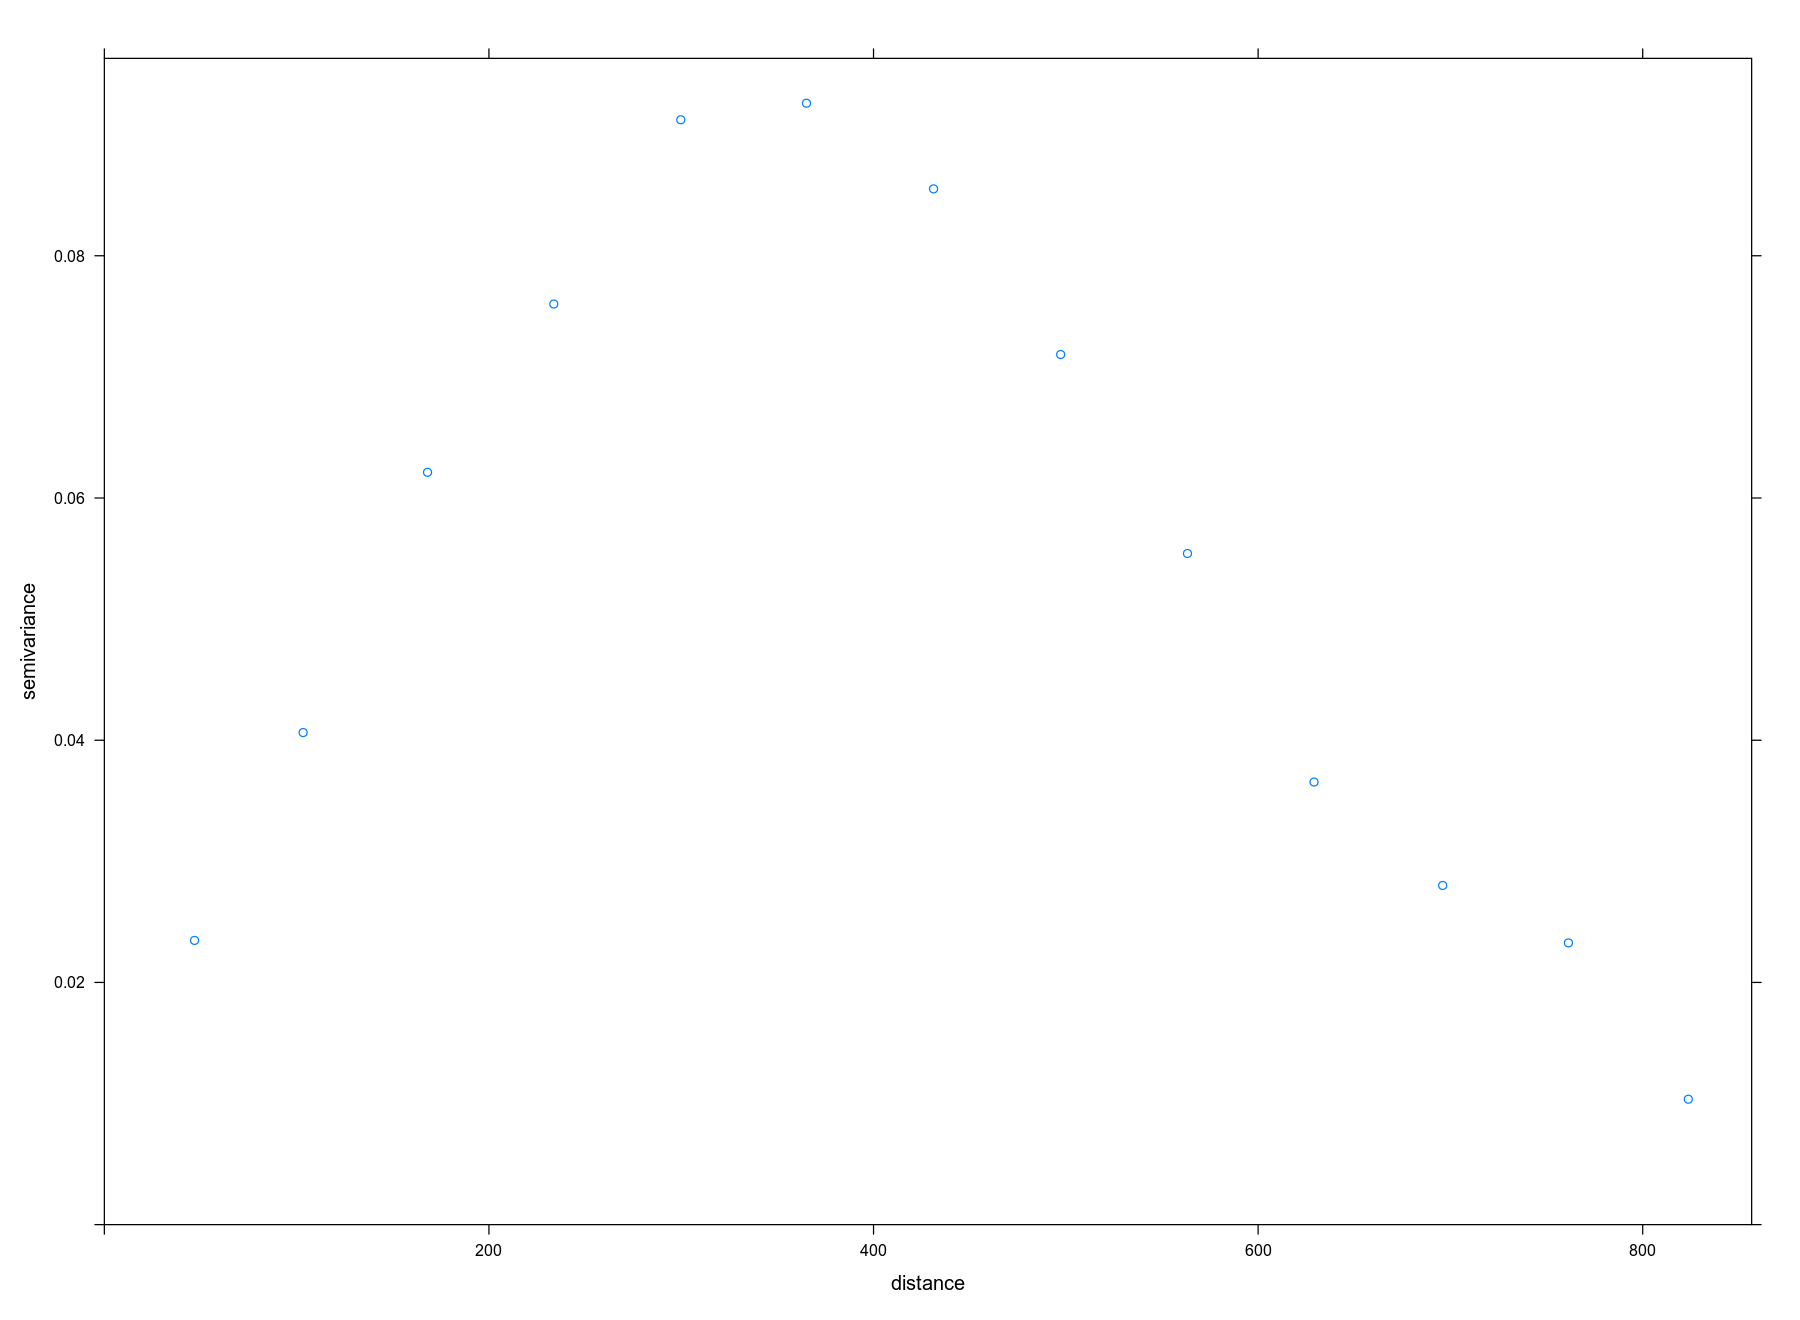

In [55]:
pad_mds %>% 
    variogram(g ~ 1, ., cloud=F, cutoff=1000) -> pad.v
pad.v %>% plot()

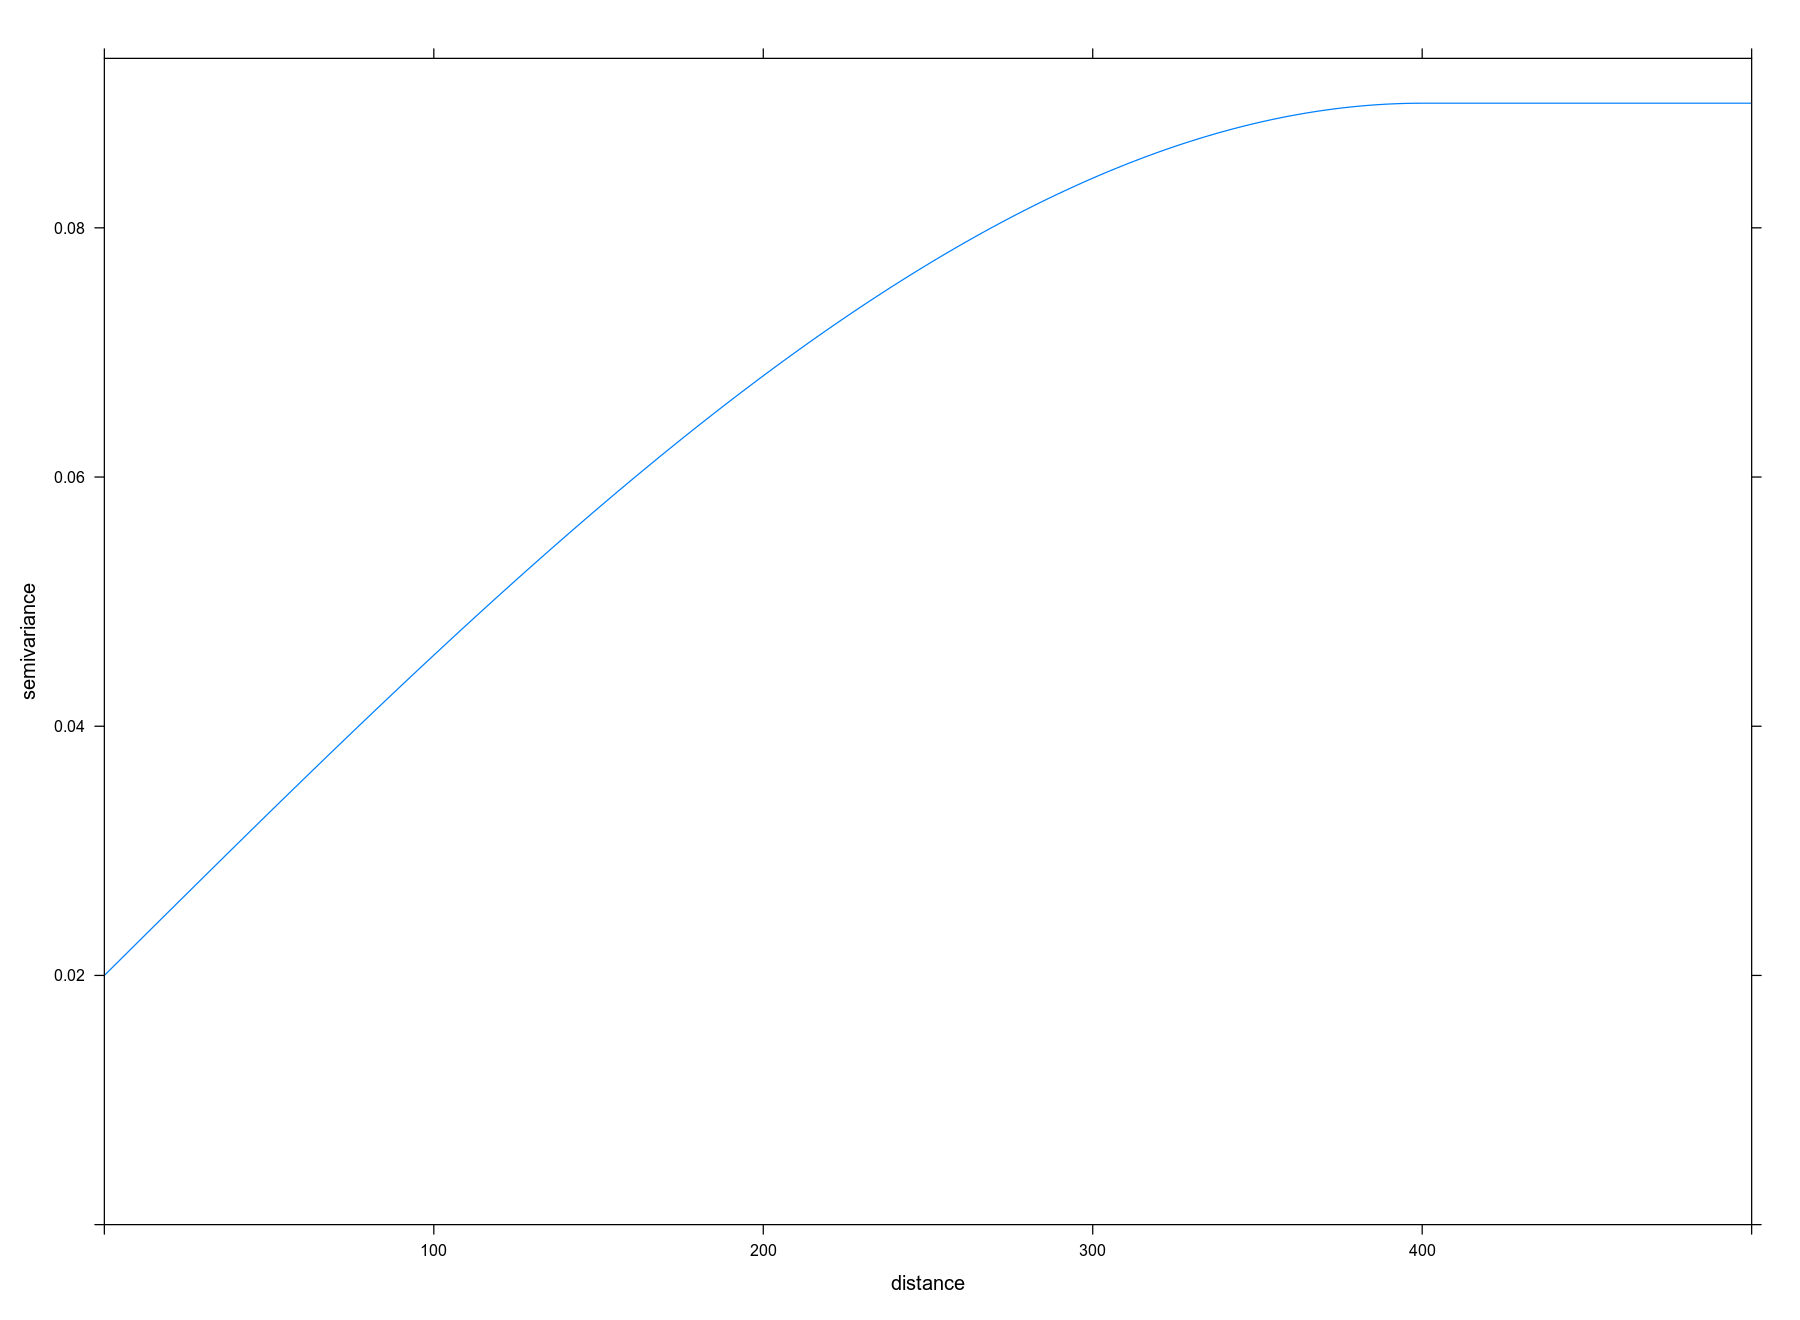

In [56]:
myVariogramModel <- vgm(psill=0.07, "Sph", range=400, nugget=0.02)

plot(myVariogramModel, cutoff=500)

In [57]:
pad.vfit <- fit.variogram(pad.v, myVariogramModel, fit.ranges=F)


In [58]:
pad.krige <- krige(g ~ 1, pad_mds, pad_grid, pad.vfit)

[using ordinary kriging]


In [59]:
pad.krige.raster <- pad.krige %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = var1.pred) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

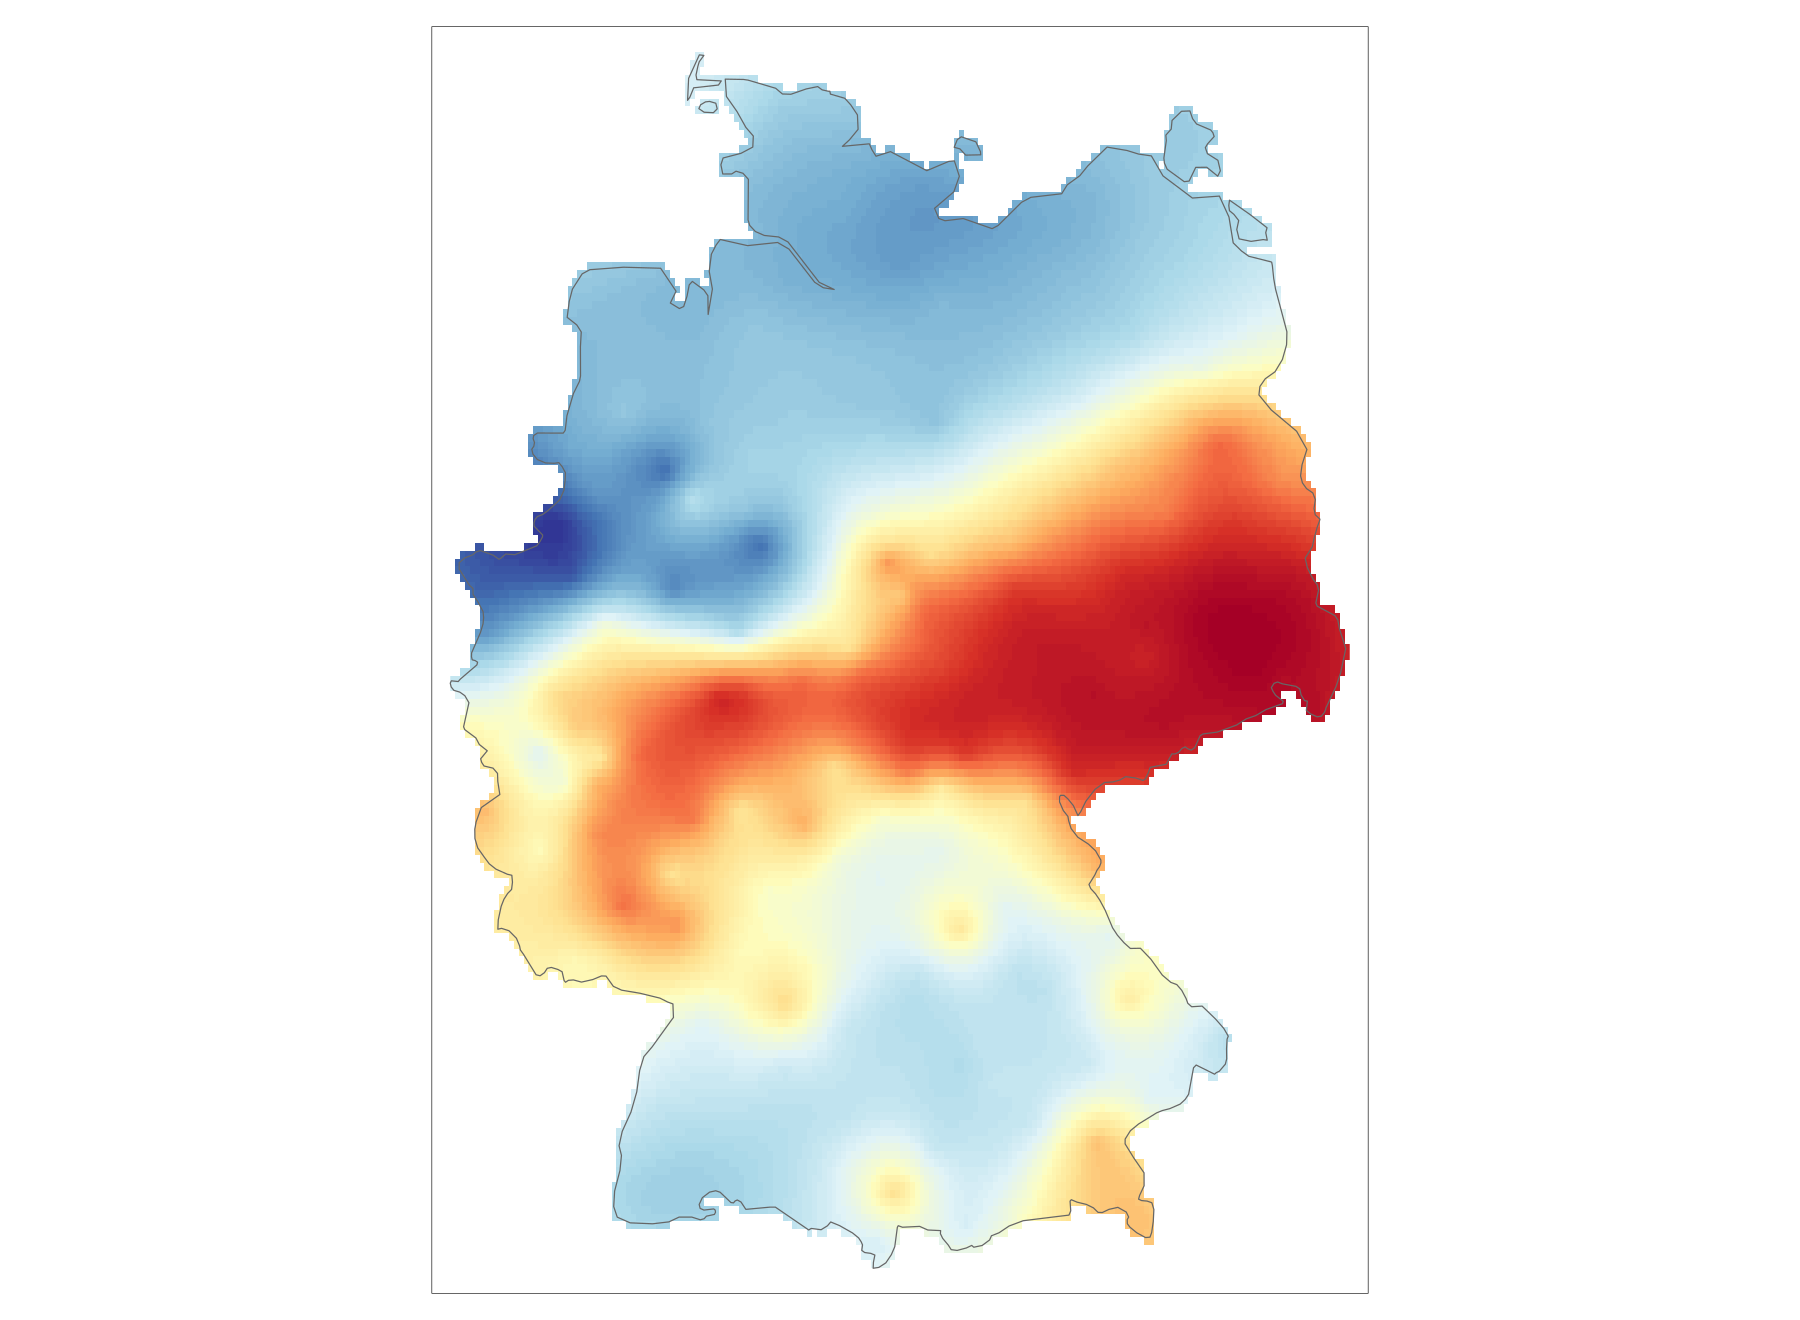

In [60]:
mask(pad.krige.raster, vect(germany)) %>%
    tm_shape() +
    tm_raster(palette = "RdYlBu", legend.show = F, style="cont") +
    tm_shape(st_sfc(germany)) +
    tm_borders()

In [61]:
pad_mds %>%
    cbind(., st_coordinates(.)) %>%
    select(g, X, Y) %>%
    mgcv::gam(g ~ s(X,Y), data=.) -> gam.fit

In [62]:
gam.prediction <- predict(gam.fit, newdata = data.frame(st_coordinates(pad_grid)))

In [63]:
pad.gam <- pad.krige %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = gam.prediction) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

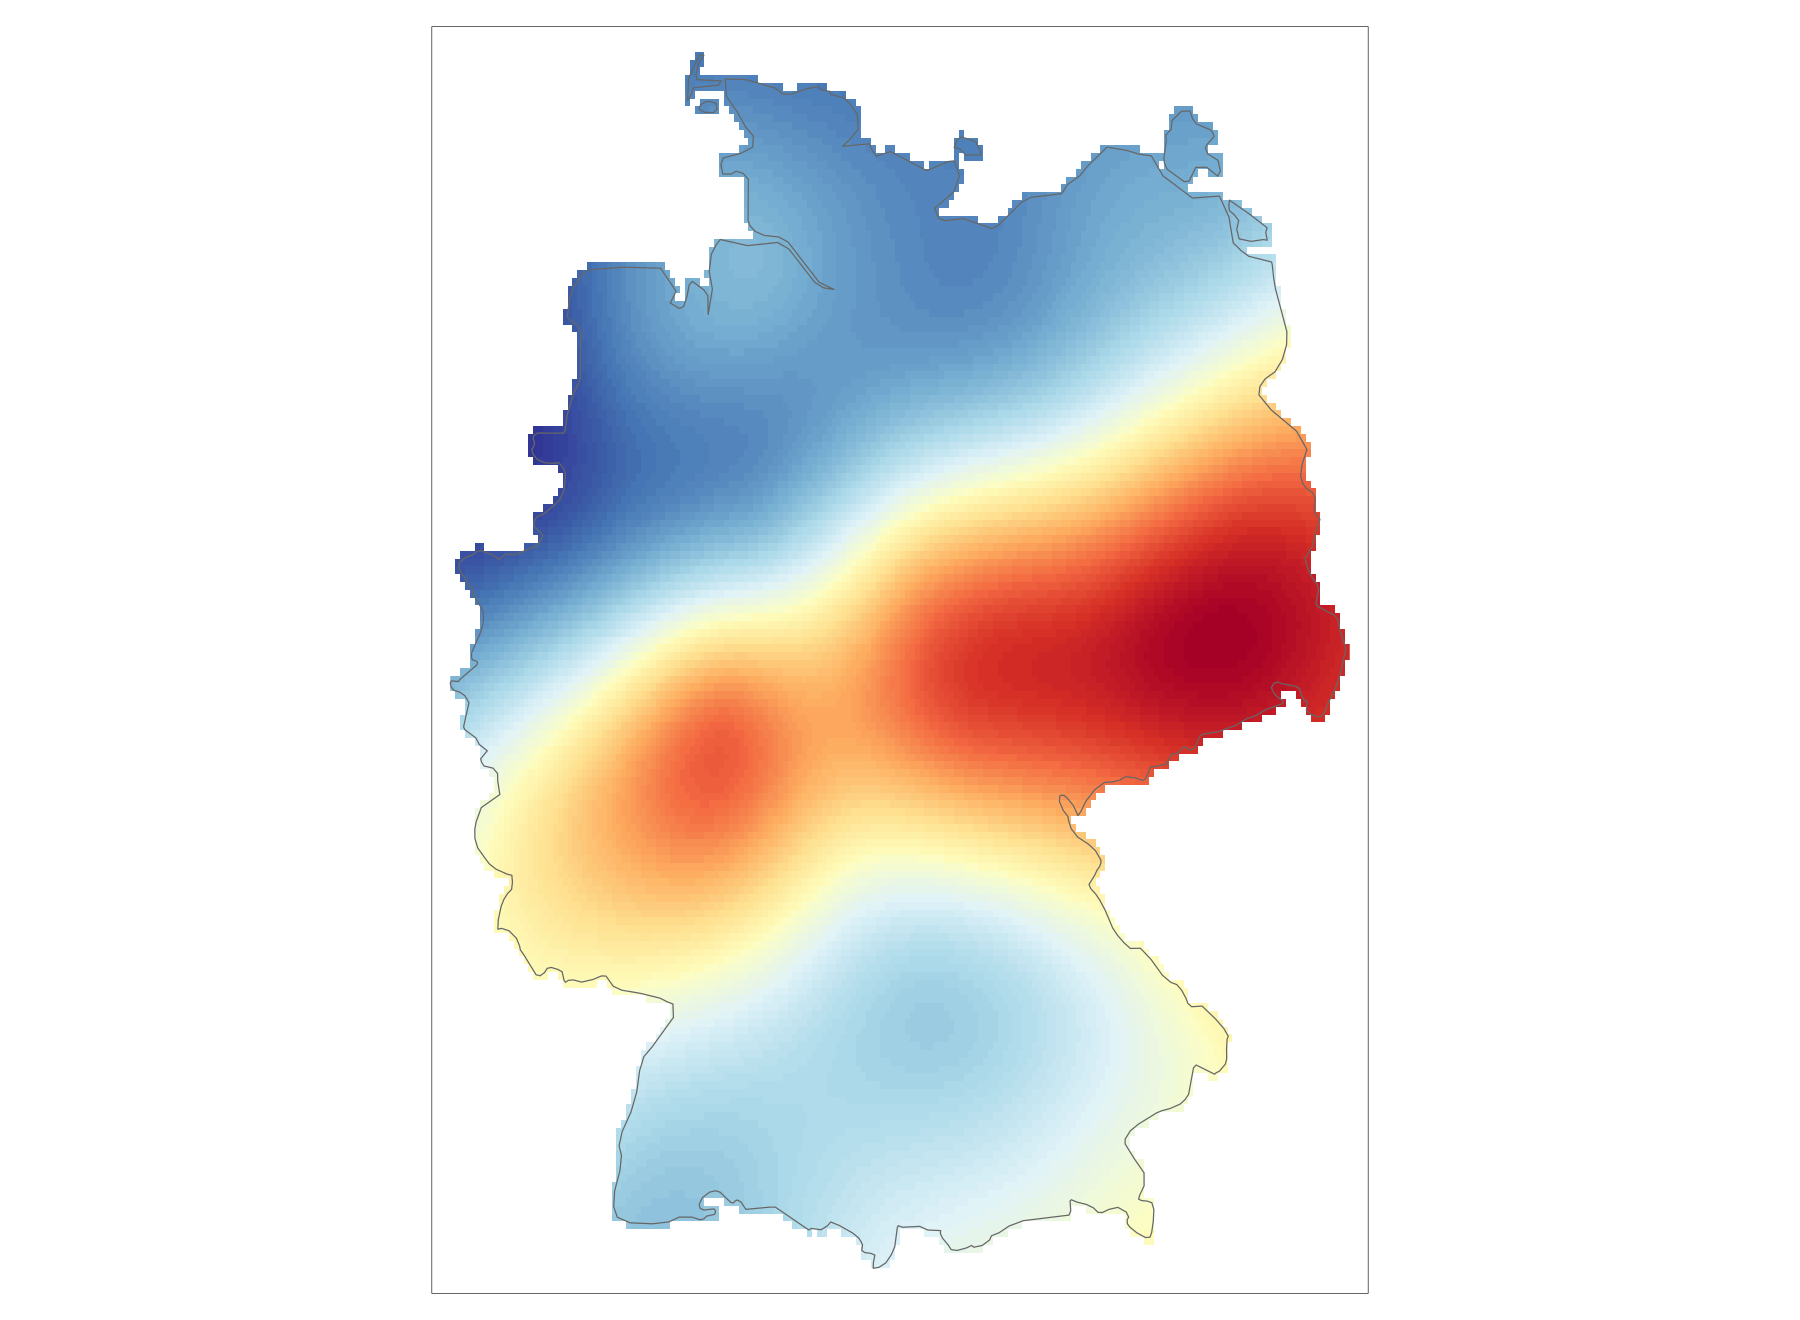

In [64]:
mask(pad.gam, vect(germany)) %>%
    tm_shape() +
    tm_raster(palette = "RdYlBu", legend.show = F, style="cont") +
    tm_shape(st_sfc(germany)) +
    tm_borders()

### Third dimension

In [65]:
pad.idw <- idw(b ~ 1, location = pad_mds, newdata = pad_grid, idp=2)

[inverse distance weighted interpolation]


In [66]:
pad.idw.raster <- pad.idw %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = var1.pred) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

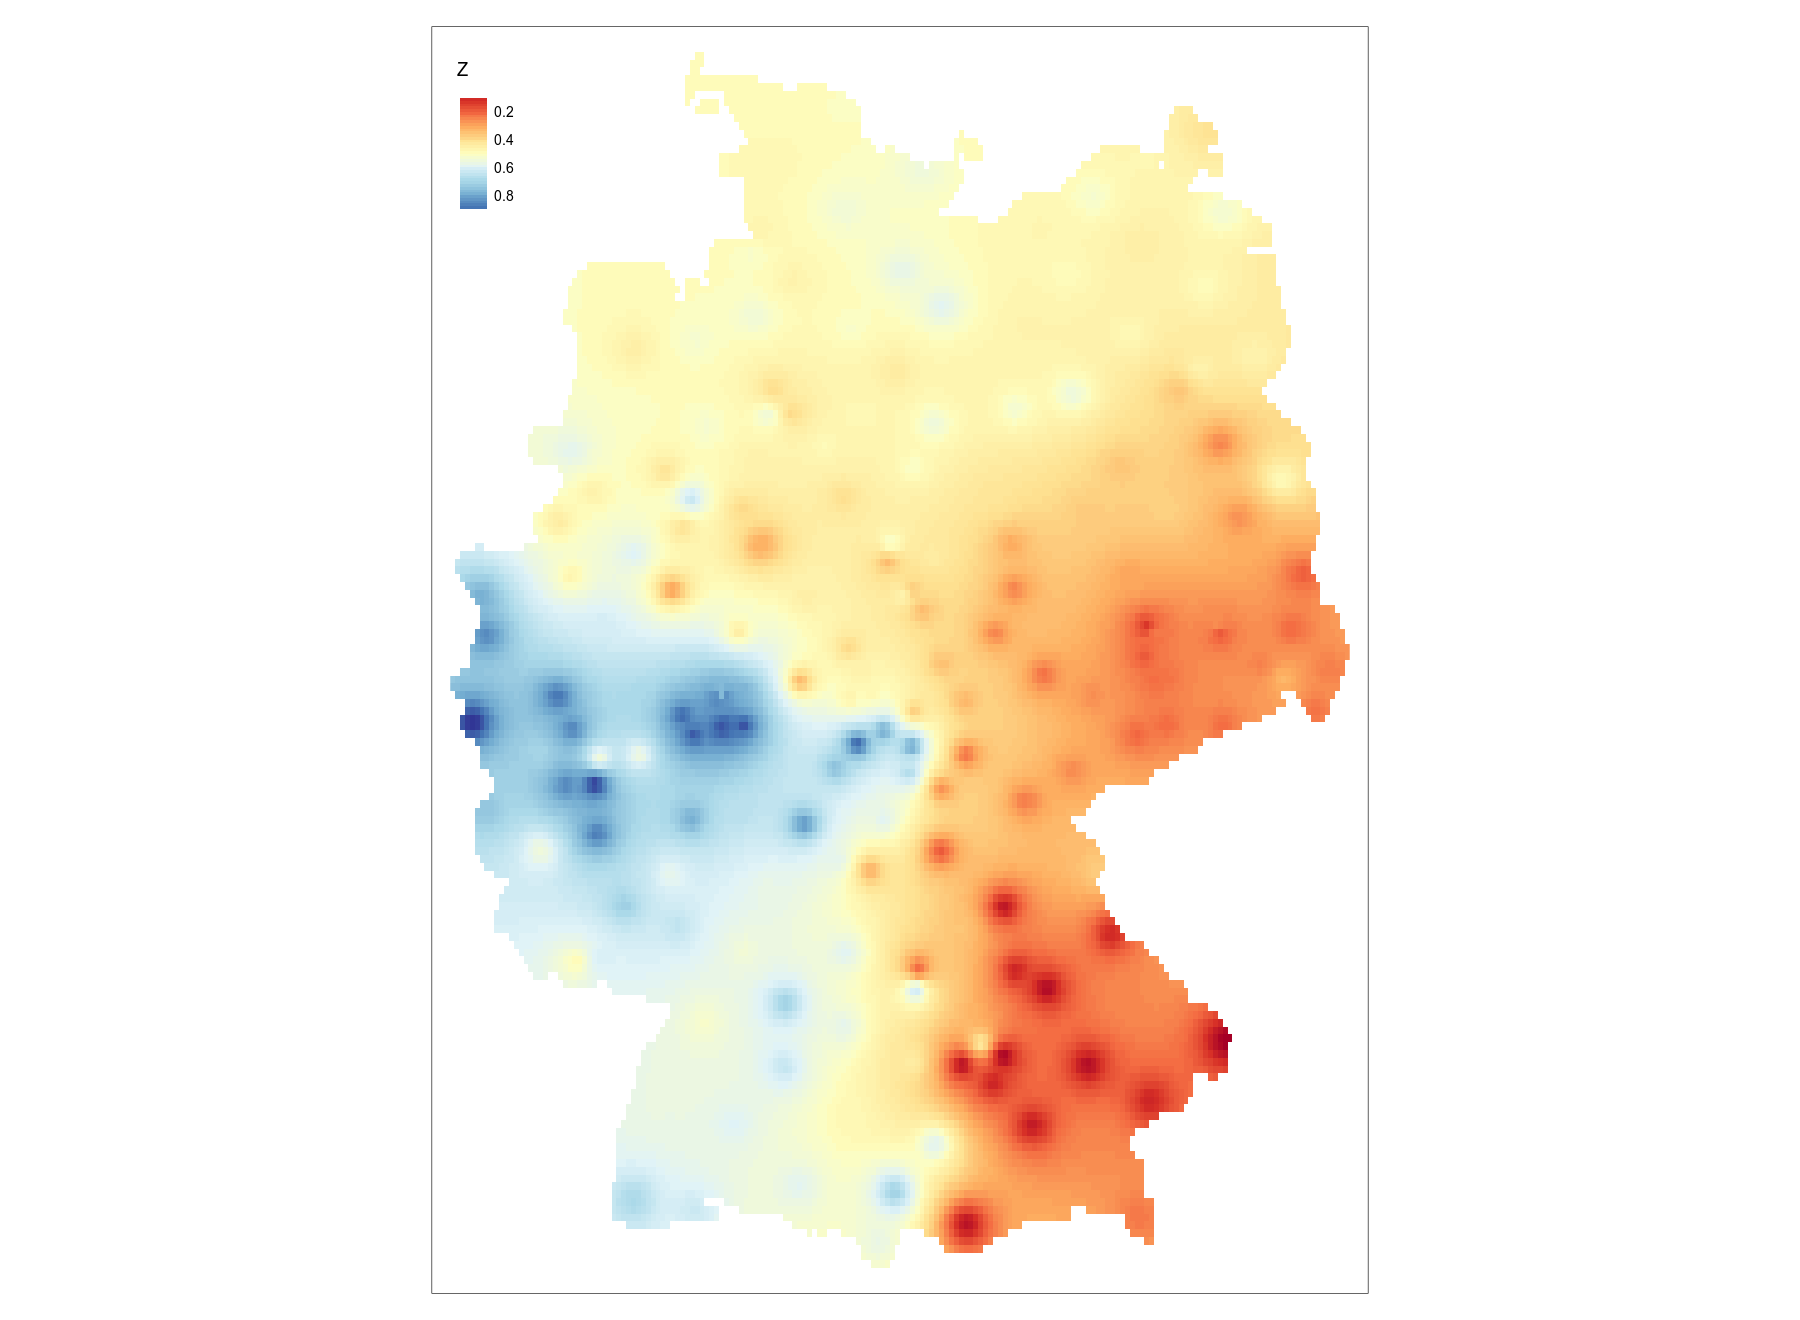

In [67]:
mask(pad.idw.raster, vect(germany)) %>%
    tm_shape() +
    tm_raster(style = "cont", palette = "RdYlBu", legend.show = TRUE)

## Ordinary Kriging

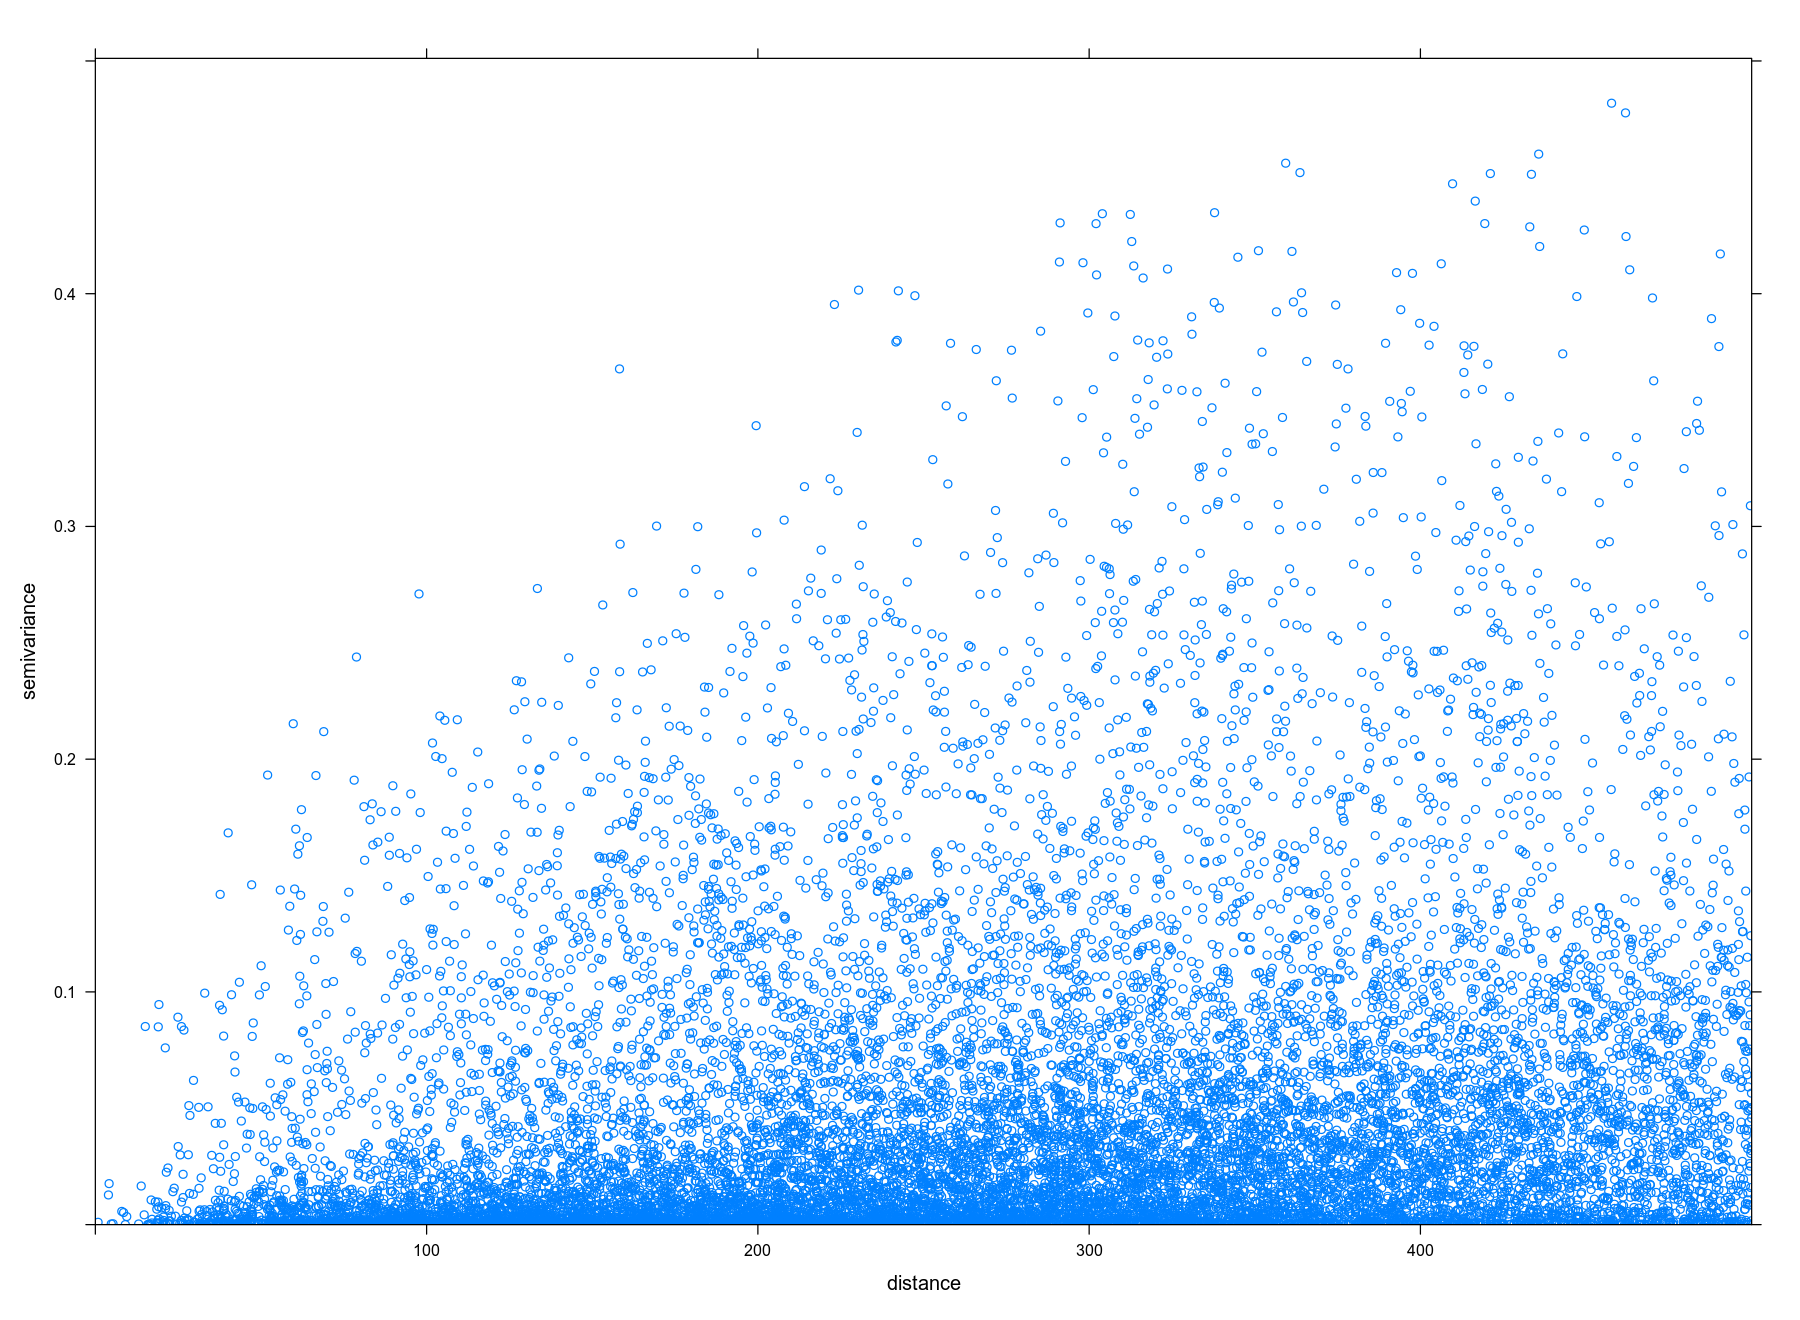

In [68]:
pad_mds %>% 
    variogram(b~ 1, ., cloud=T, cutoff=500) %>%
    plot()


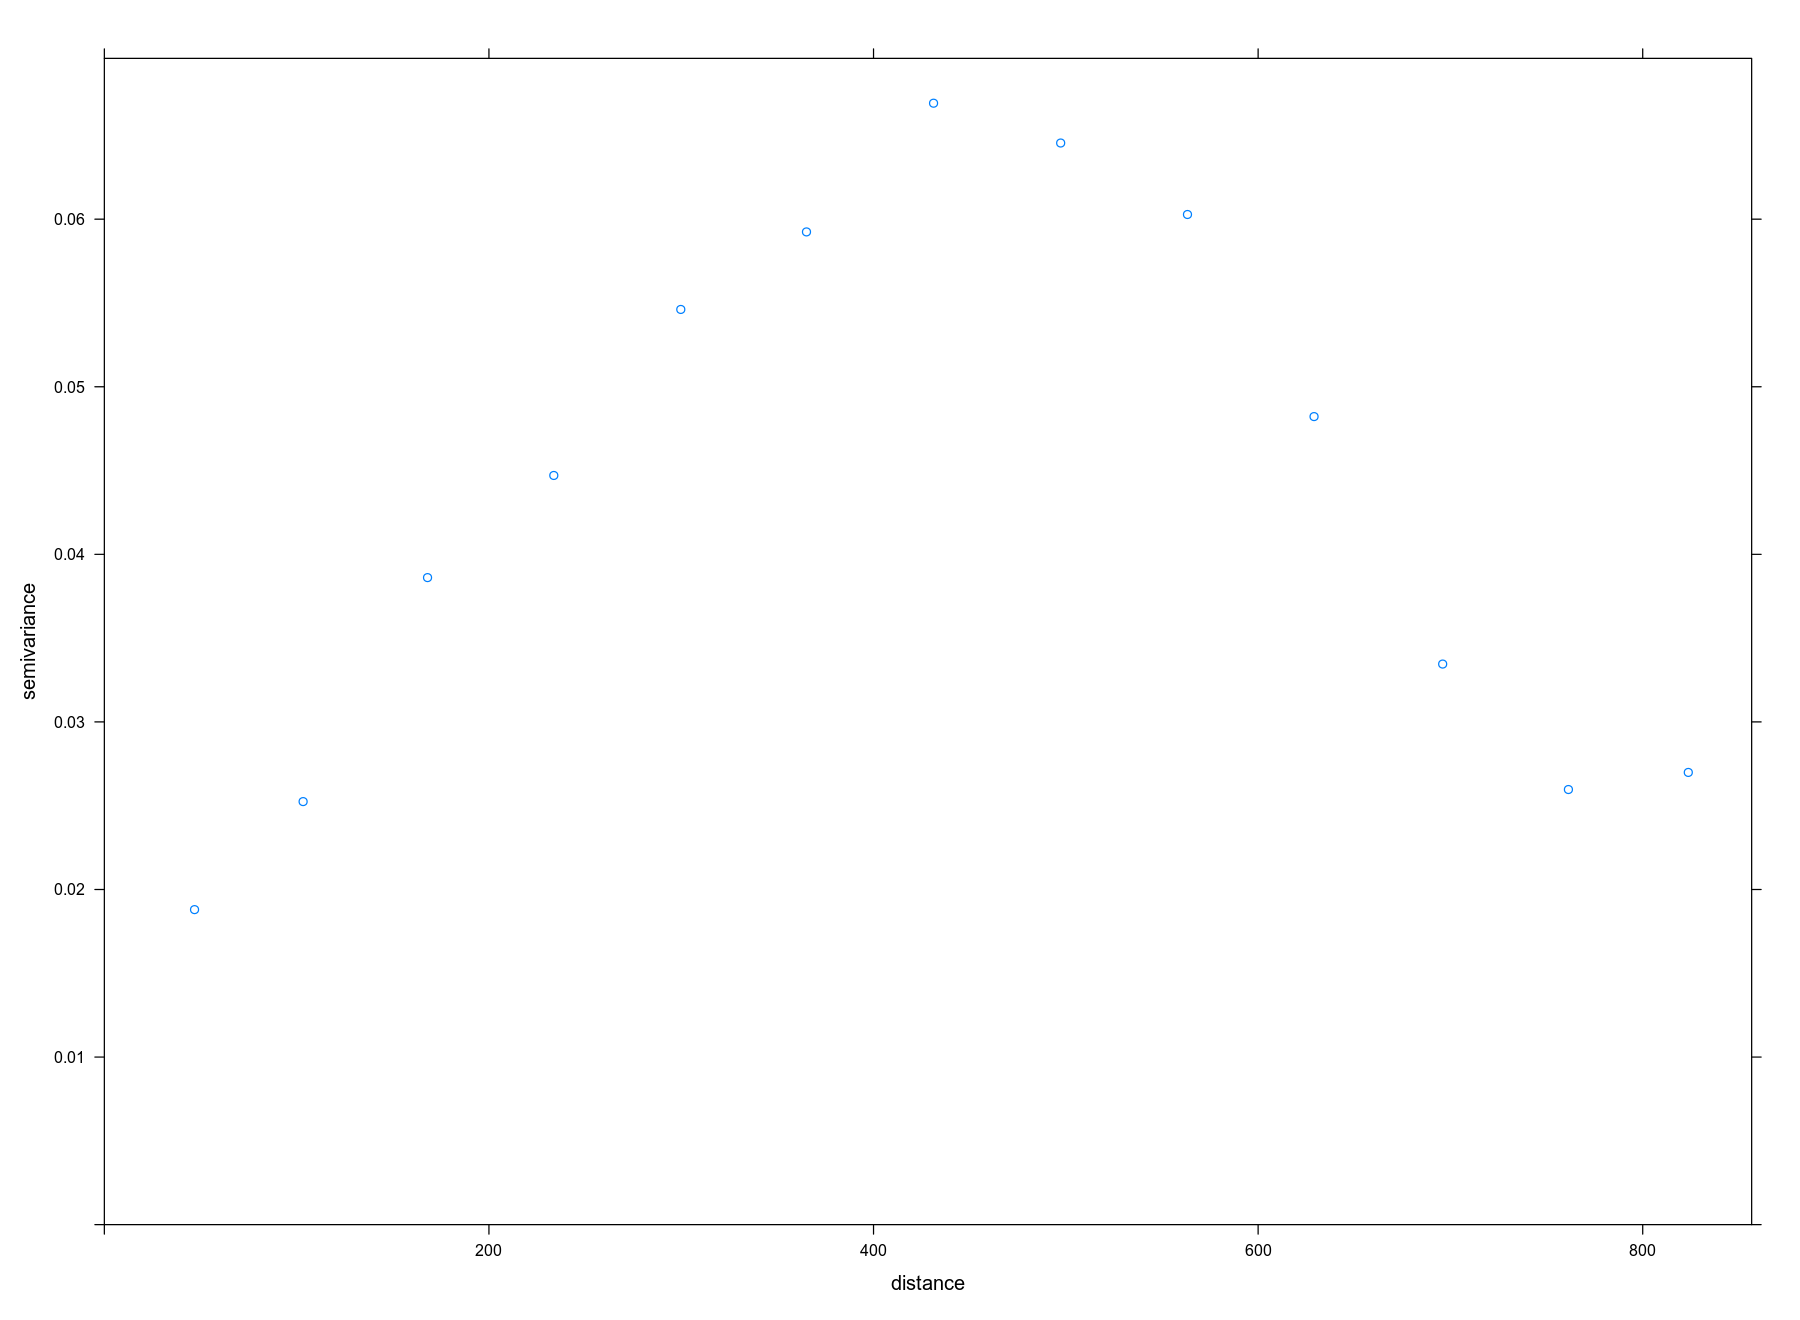

In [69]:
pad_mds %>% 
    variogram(b ~ 1, ., cloud=F, cutoff=1000) -> pad.v
pad.v %>% plot()

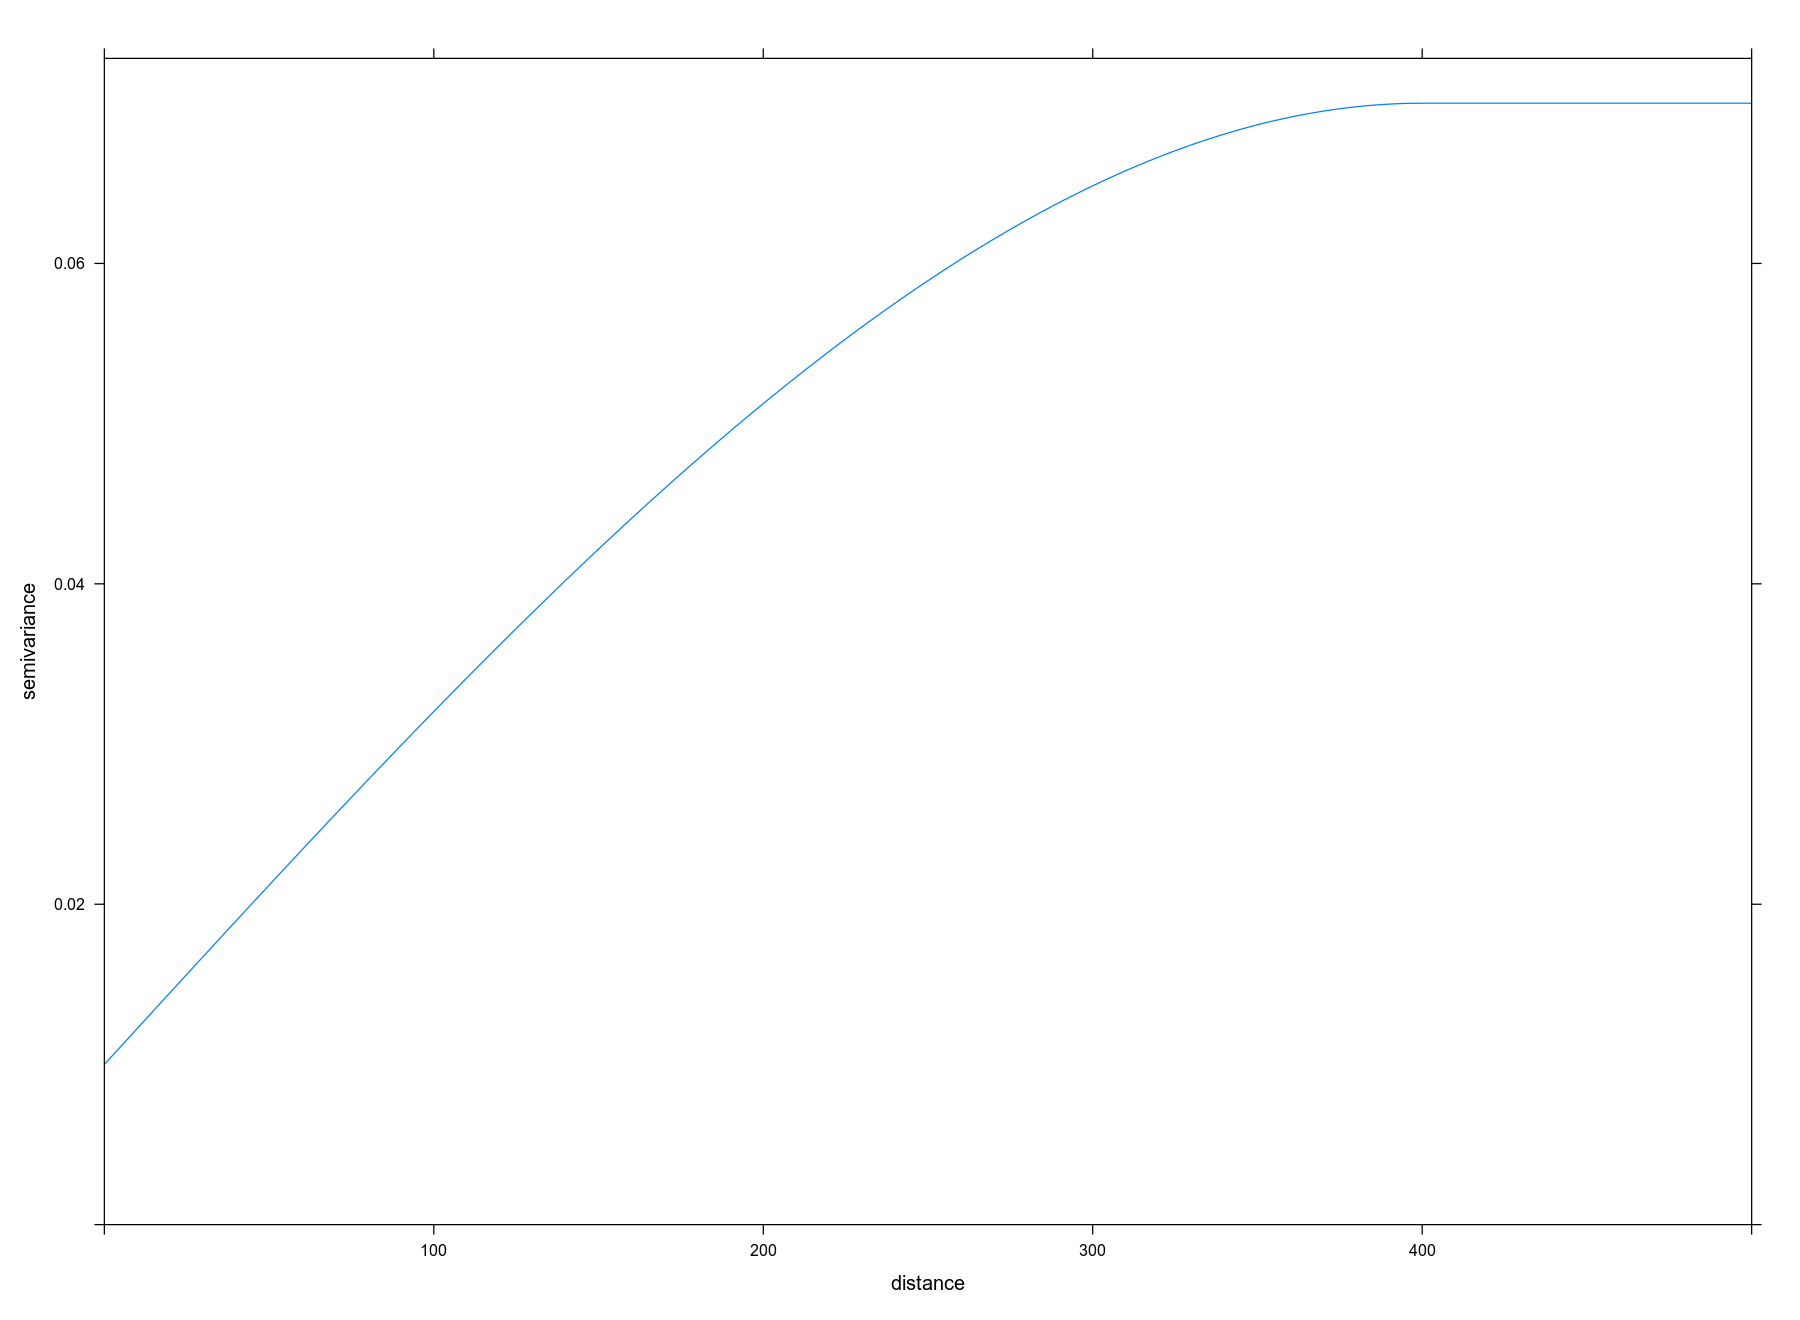

In [70]:
myVariogramModel <- vgm(psill=0.06, "Sph", range=400, nugget=0.01)

plot(myVariogramModel, cutoff=500)

In [71]:
pad.vfit <- fit.variogram(pad.v, myVariogramModel, fit.ranges=F)


In [72]:
pad.krige <- krige(b ~ 1, pad_mds, pad_grid, pad.vfit)

[using ordinary kriging]


In [73]:
pad.krige.raster <- pad.krige %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = var1.pred) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

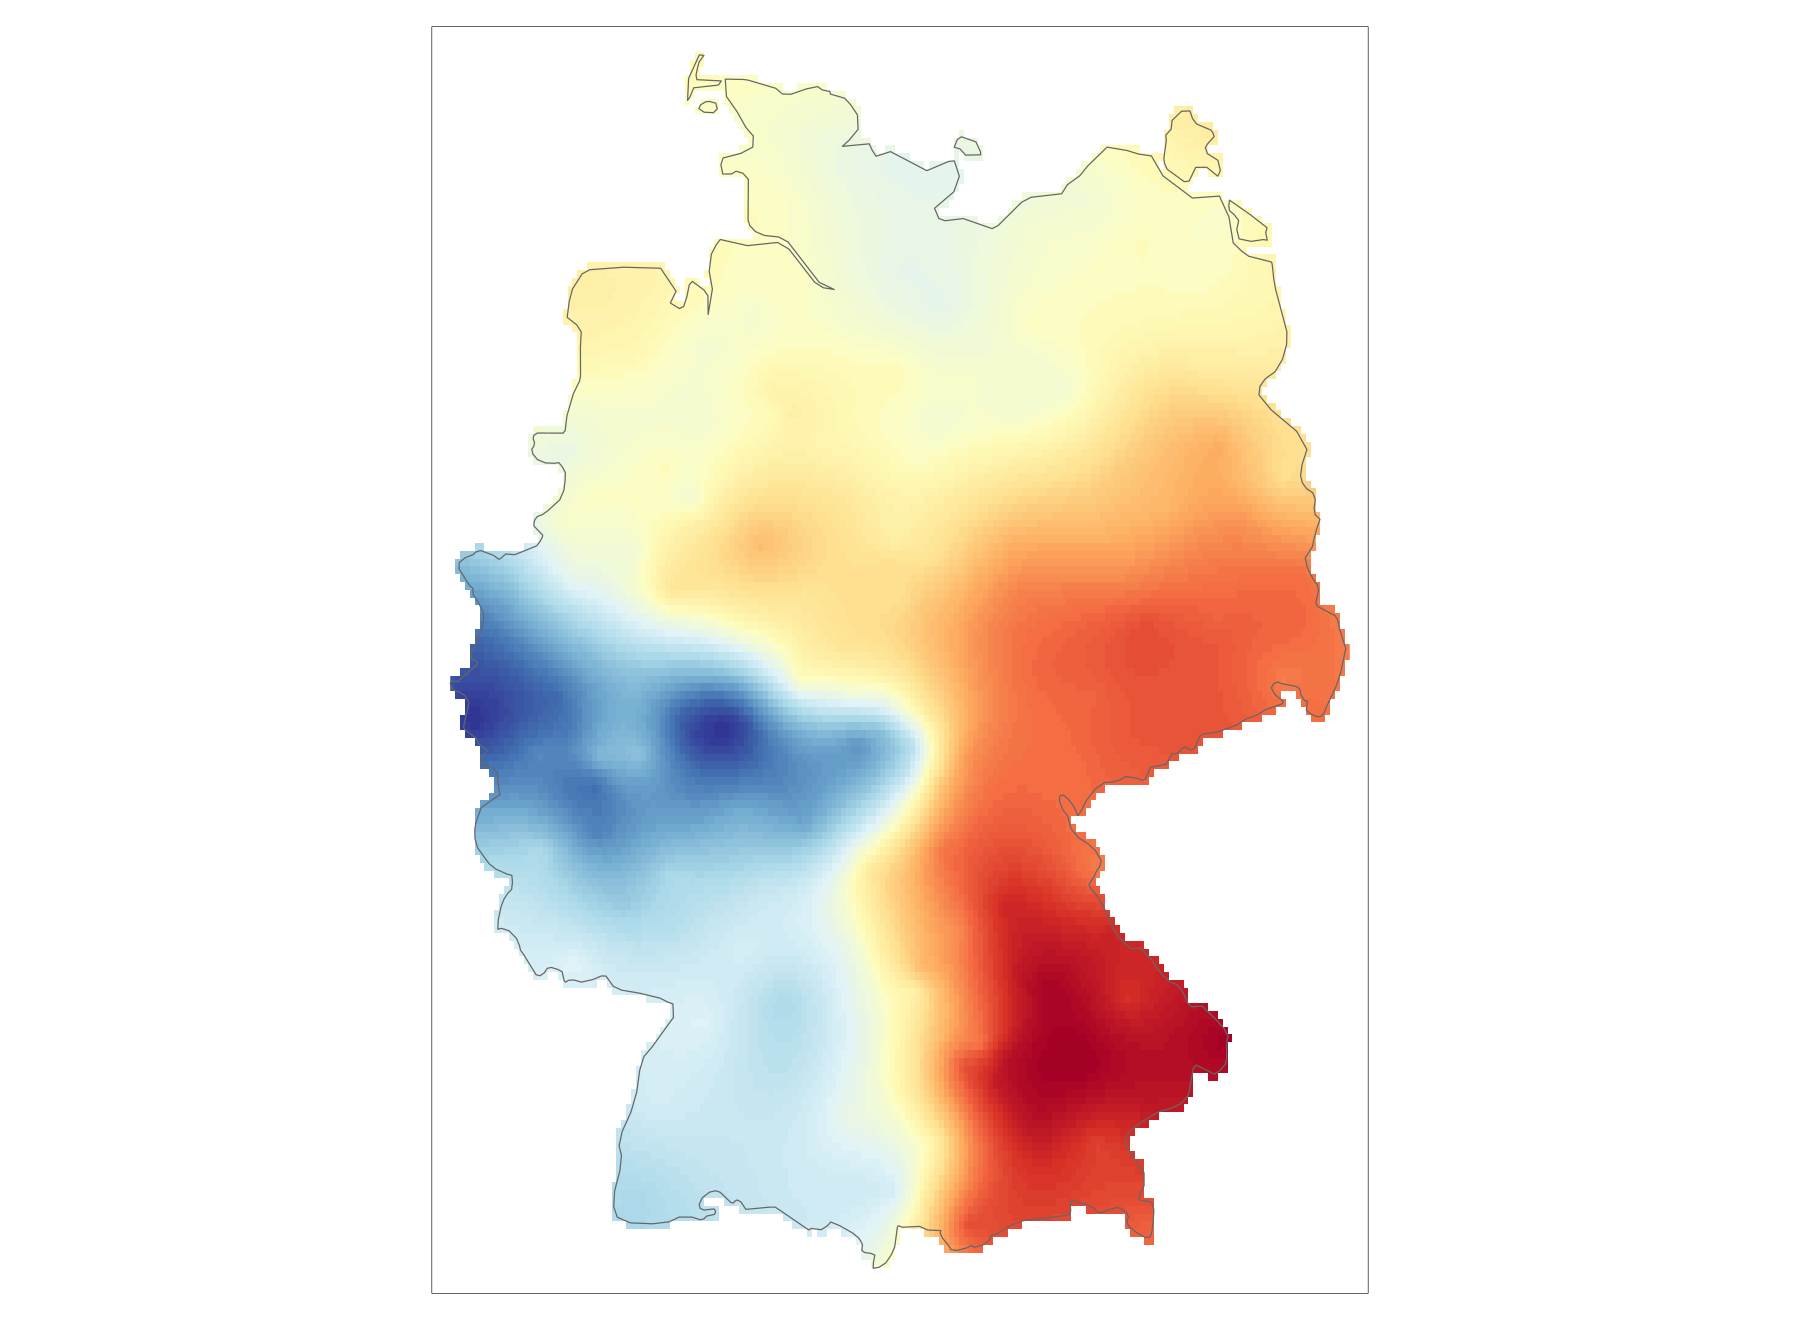

In [74]:
mask(pad.krige.raster, vect(germany)) %>%
    tm_shape() +
    tm_raster(palette = "RdYlBu", legend.show = F, style="cont") +
    tm_shape(st_sfc(germany)) +
    tm_borders()

In [75]:
pad_mds %>%
    cbind(., st_coordinates(.)) %>%
    select(b, X, Y) %>%
    mgcv::gam(b ~ s(X,Y), data=.) -> gam.fit

In [76]:
gam.prediction <- predict(gam.fit, newdata = data.frame(st_coordinates(pad_grid)))

In [77]:
pad.gam <- pad.krige %>%
    cbind(., st_coordinates(.)) %>%
    st_drop_geometry() %>%
    mutate(Z = gam.prediction) %>%
    select(X, Y, Z) %>%
    raster::rasterFromXYZ(crs=4326) %>%
    as("SpatRaster")

Warning message in x@ptr$mask_vector(mask@ptr, inverse[1], updatevalue[1], touches[1], :
“GDAL Message 1: Failed to fetch spatial reference on layer lyr to build transformer, assuming matching coordinate systems.”

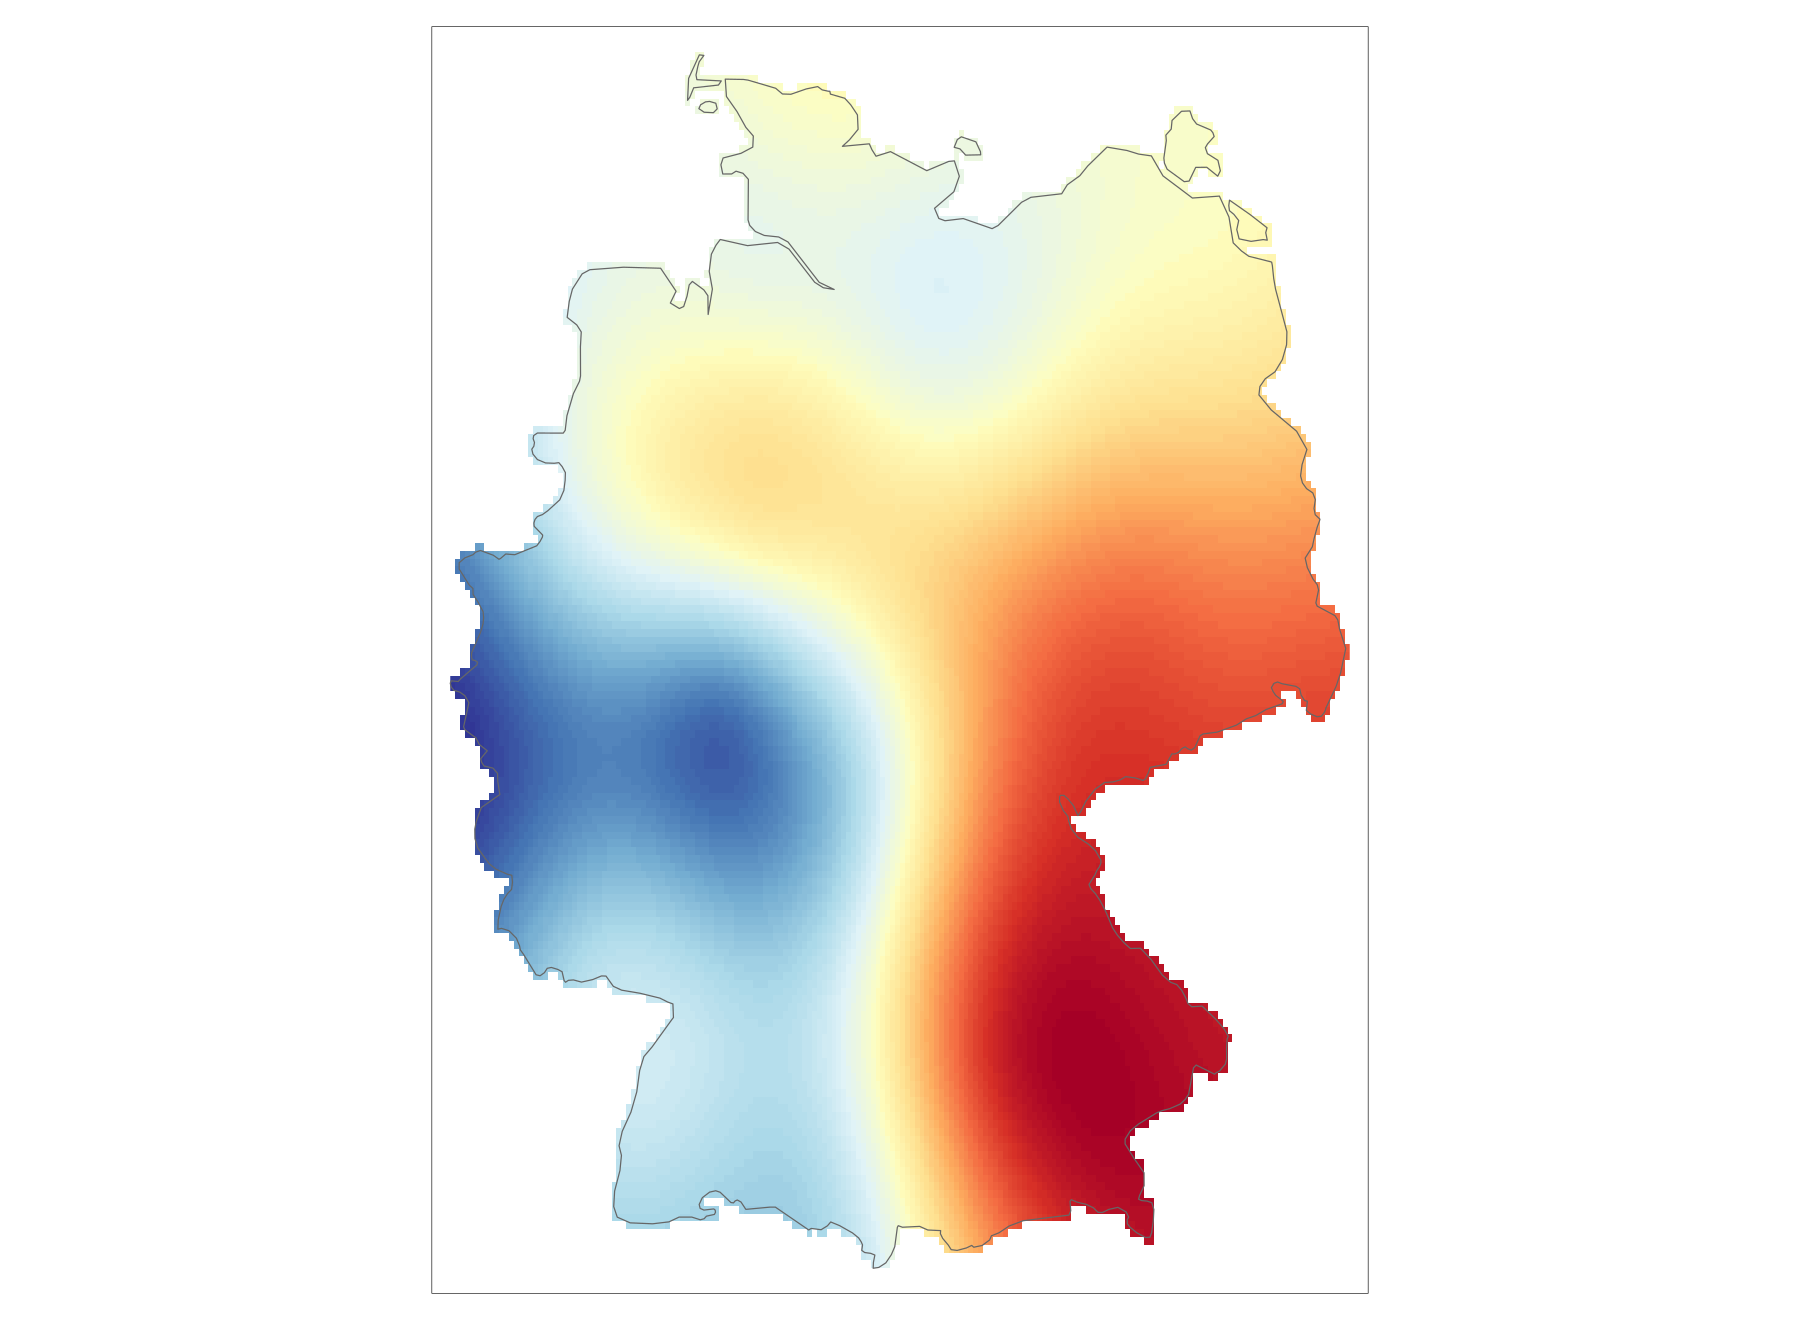

In [78]:
mask(pad.gam, vect(germany)) %>%
    tm_shape() +
    tm_raster(palette = "RdYlBu", legend.show = F, style="cont") +
    tm_shape(st_sfc(germany)) +
    tm_borders()

# Topics for term projects

## 1. What features characterize the dialect areas in the PAD? (2 students)

The 3 dominant MDS dimensions each clearly splits the German dialects into two regions. Identify the linguistic features that have the strongest association with these dimensions.

## 2. Consonant-vowel ratio and latitude correlation: model comparison

We found a strong correlation between the absolute latitude and the consonant-vowel ratio of languages. Conduct two mixed-effects regression models for these data:

- using language family as random effect
- using linguistic macro-area as random effect.

Compare these two models with the spatial error model via AIC.

## 3. Cross-validation for PAD/MDS data (2 students)

In the last session I demonstrated three techniques for spatial interpolation - inverse distance weighting, ordinary Kriging and Generalized Additive Models. Compare the quality of these approaches using cross-validation.

## 4. MDS for NorthEuraLex (2 students)

The database at http://northeuralex.org/ contains lexical data for ca. 100 languages from Northern Eurasia.

- Compute pairwise distances between these languages. (You may use the Python library https://lingpy.org/ for this.)

- Apply Multi-Dimensional Scaling to these distances and extract the 3 most important dimensions.

- Using spatial interpolation, visualize these dimensions on a map.